In [1]:
# !gsutil cp -r gs://volume_ai_1yr_daily_data/* /home/jupyter/lstm/

In [ ]:
# !pip install captum

## Install Package

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from plotnine import *
from plotnine.data import *
import random
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR
from captum.attr import IntegratedGradients
from plotnine.data import *
import seaborn as sns
import gc

## Import Training Data

In [5]:
X_30d_minmaxscaler = np.load('/home/jupyter/lstm/training_array/X_30d_minmaxscaler_feaonly_first4mon_202401_03.npy')
y_30d_minmaxscaler = np.load('/home/jupyter/lstm/training_array/y_30d_minmaxscaler_feaonly_first4mon_202401_03.npy')

In [28]:
user_df_minmaxscaler = np.load('/home/jupyter/lstm/training_array/static_array_first4mon_202401_03.npy')

### Split Train-Test data

In [6]:
X_train_all, X_test, y_train_all, y_test, fea_train_all, fea_test = train_test_split(X_30d_minmaxscaler, y_30d_minmaxscaler, user_array, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, fea_train, fea_val = train_test_split(X_train_all, y_train_all, fea_train_all, test_size=0.1, random_state=42)

In [7]:
y_train.sum()/len(y_train)

0.8392102252946735

In [8]:
y_test.sum()/len(y_test)

0.8376152537821144

In [9]:
y_val.sum()/len(y_val)

0.8379950771984784

In [10]:
X_train.shape

(40214, 4, 69)

In [11]:
fea_train.shape

(40214, 29)

In [12]:
y_train.shape

(40214,)

In [13]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
fea_train = torch.from_numpy(fea_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
fea_test = torch.from_numpy(fea_test).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().unsqueeze(-1)
fea_val = torch.from_numpy(fea_val).float()

In [14]:
# analysis use
X_torch = torch.from_numpy(X_30d_minmaxscaler).float()
y_torch = torch.from_numpy(y_30d_minmaxscaler).float().unsqueeze(-1)
fea_torch = torch.from_numpy(user_array).float()

### Upsampling

In [125]:
active_indices = np.where(y_train_all == 1)[0]
non_active_indices = np.where(y_train_all == 0)[0]

In [126]:
non_active_upsampled = resample(non_active_indices, replace=True, n_samples=len(active_indices), random_state=0)
balanced_indices = np.concatenate([active_indices, non_active_upsampled])

In [127]:
X_train_all_balanced = X_train_all[balanced_indices]
y_train_all_balanced = y_train_all[balanced_indices]

In [128]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all_balanced, y_train_all_balanced, test_size=0.1, random_state=42)

In [129]:
y_train.sum()/len(y_train)

0.49926614481409004

In [130]:
y_val.sum()/len(y_val)

0.5066042927903137

In [131]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
# X_test = torch.from_numpy(X_test).float()
# y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().unsqueeze(-1)

## Performance Evaluation Function

In [108]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_test_list = []
        y_pred_list = [] 
        for seq, labels in zip(X_test, y_test):
            seq, labels = seq.to(device).float(), labels.to(device).float()
            y_pred = model(seq.unsqueeze(0))
            y_pred = (y_pred > 0.5).float()
            
            y_test_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
    
    
    target_names = ['Non-Active', 'Active']
    print(classification_report(y_test_list, y_pred_list, target_names=target_names))

In [15]:
def evaluate_model(model, X_test, y_test, fea_test):
    model.eval()
    with torch.no_grad():
        y_test_list = []
        y_pred_list = [] 
        for seq, labels, feature in zip(X_test, y_test, fea_test):
            seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
            y_pred = model(seq.unsqueeze(0), feature.unsqueeze(0))
            y_pred = (y_pred > 0.5).float()
            
            y_test_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
    
    
    target_names = ['Non-Active', 'Active']
    print(classification_report(y_test_list, y_pred_list, target_names=target_names))

## GRU Model, Add Static feature layer

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
batch_size = 32

dataset_train = TensorDataset(X_train, y_train, fea_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val, fea_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [21]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, feature_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.extracter = nn.Linear(input_dim, input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.mid_fc = nn.Linear(hidden_dim, hidden_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim)
        self.fc = nn.Linear(hidden_dim + feature_dim, output_dim)
    
    def forward(self, x, important_features):
        # x: (batch_size, seq_len, input_dim)
        x = self.dropout(self.relu(self.extracter(x)))
        output, hidden = self.gru(x)
        mid_output = self.dropout(self.relu(self.mid_fc(output[:, -1, :])))
        concat_input = torch.cat((mid_output, important_features), dim=1)  # (batch_size, hidden_dim + feature_dim)
        output = torch.sigmoid(self.fc(concat_input))
        return output

In [22]:
model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device) # input_dim, hidden_dim, output_dim

# Loss function & Optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01) # , weight_decay=0.01

# Learning rate scheduler
epochs = 100
total_steps = len(dataloader_train) * epochs
scheduler = OneCycleLR(optimizer, max_lr=0.0001, total_steps=total_steps, epochs=epochs)

In [23]:
def train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs):
    
    # patience = 20
    best_val_loss = float('inf')
    # counter = 0
    # epoch = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        epoch += 1
        for batch in dataloader_train:
            seqs, labels, features = batch
            seqs, labels, features = seqs.to(device).float(), labels.to(device).float(), features.to(device).float(),
            optimizer.zero_grad()

            y_pred = model(seqs, features)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        train_losses.append(loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels, features = batch
                seqs, labels, features = seqs.to(device).float(), labels.to(device).float(), features.to(device).float(),
                val_pred = model(seqs, features)
                val_pred = val_pred
                labels = labels
                val_loss = loss_function(val_pred, labels)
            val_losses.append(val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {loss.item():10.8f}, Val Loss: {val_loss.item():10.8f}')
            current_lr = scheduler.get_last_lr()[0]
            print(f'Epoch {epoch:3}, Loss: {loss.item()}, Learning Rate: {current_lr}')


                
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea_first4mon.pt')
    
    
    plt.plot(list(range(1, epochs+1, 1)), val_losses)
    plt.plot(list(range(1, epochs+1, 1)), train_losses)
    plt.xlabel('Model Complexity')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. Model Complexity')
    plt.show()

### Static Data Concat

#### Final Model

 10%|█         | 10/100 [00:38<05:47,  3.86s/it]

Epoch  10, Train Loss: 0.17129144, Val Loss: 0.33350199
Epoch  10, Loss: 0.17129144072532654, Learning Rate: 2.800115440700391e-05


 20%|██        | 20/100 [01:17<05:07,  3.85s/it]

Epoch  20, Train Loss: 0.29069829, Val Loss: 0.29834172
Epoch  20, Loss: 0.2906982898712158, Learning Rate: 7.60023087584805e-05


 30%|███       | 30/100 [01:55<04:28,  3.83s/it]

Epoch  30, Train Loss: 0.29749402, Val Loss: 0.12137920
Epoch  30, Loss: 0.2974940240383148, Learning Rate: 9.999999996813078e-05


 40%|████      | 40/100 [02:34<03:49,  3.82s/it]

Epoch  40, Train Loss: 0.25750342, Val Loss: 0.27815869
Epoch  40, Loss: 0.2575034201145172, Learning Rate: 9.504768860705023e-05


 50%|█████     | 50/100 [03:12<03:11,  3.83s/it]

Epoch  50, Train Loss: 0.21424437, Val Loss: 0.24807462
Epoch  50, Loss: 0.21424436569213867, Learning Rate: 8.117316965615154e-05


 60%|██████    | 60/100 [03:50<02:32,  3.82s/it]

Epoch  60, Train Loss: 0.17890437, Val Loss: 0.18598947
Epoch  60, Loss: 0.17890436947345734, Learning Rate: 6.112446175346842e-05


 70%|███████   | 70/100 [04:28<01:54,  3.80s/it]

Epoch  70, Train Loss: 0.27366138, Val Loss: 0.27417797
Epoch  70, Loss: 0.27366137504577637, Learning Rate: 3.88724573803937e-05


 80%|████████  | 80/100 [05:07<01:17,  3.87s/it]

Epoch  80, Train Loss: 0.32966918, Val Loss: 0.26438719
Epoch  80, Loss: 0.32966917753219604, Learning Rate: 1.8824438905939206e-05


 90%|█████████ | 90/100 [05:45<00:38,  3.83s/it]

Epoch  90, Train Loss: 0.35073099, Val Loss: 0.10550983
Epoch  90, Loss: 0.3507309854030609, Learning Rate: 4.951162261781821e-06


100%|██████████| 100/100 [06:24<00:00,  3.84s/it]

Epoch 100, Train Loss: 0.19502337, Val Loss: 0.14021774
Epoch 100, Loss: 0.19502337276935577, Learning Rate: 4.000318692185736e-10


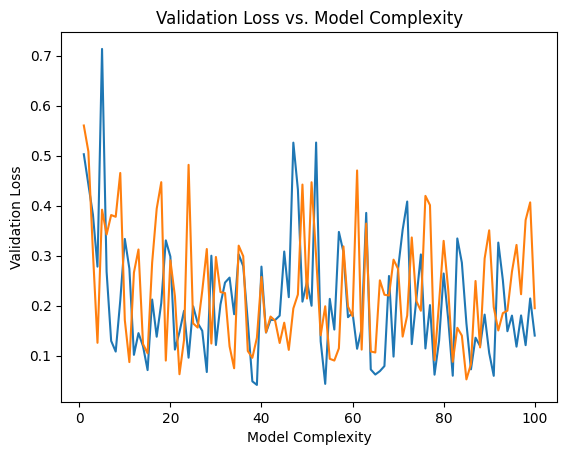

In [42]:
# Min-max Scaler (Final Version)
train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs)

In [44]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea3.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [47]:
evaluate_model(model, X_test, y_test, fea_test)

              precision    recall  f1-score   support

  Non-Active       0.77      0.72      0.74      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.84     11171
weighted avg       0.91      0.91      0.91     11171



In [45]:
evaluate_model(best_model, X_train, y_train, fea_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.73      0.76      7503
      Active       0.94      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.87      0.84      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [46]:
evaluate_model(best_model, X_val, y_val, fea_val)

              precision    recall  f1-score   support

  Non-Active       0.79      0.71      0.75       842
      Active       0.93      0.96      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.83      0.85      4469
weighted avg       0.91      0.91      0.91      4469



In [60]:
## Final Model
# Min-max Scaler
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels, feature in zip(X_test, y_test, fea_test):
        seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
        y_pred = best_model(seq.unsqueeze(0), feature.unsqueeze(0))
        y_pred = (y_pred > 0.45).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.80      0.68      0.73      2080
      Active       0.93      0.96      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.86      0.82      0.84     11171
weighted avg       0.90      0.91      0.90     11171



## Attention

In [267]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        Q = self.query(x)  # (batch_size, seq_len, hidden_dim)
        K = self.key(x)    # (batch_size, seq_len, hidden_dim)
        V = self.value(x)  # (batch_size, seq_len, hidden_dim)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(Q.shape[-1], dtype=torch.float32))
        attn_weights = self.softmax(scores)  # (batch_size, seq_len, seq_len)
        
        context = torch.matmul(attn_weights, V)  # (batch_size, seq_len, hidden_dim)
        return context, attn_weights

class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionModel, self).__init__()
        self.attention = SelfAttention(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        context, attn_weights = self.attention(x)  # context: (batch_size, seq_len, hidden_dim)
        
        # Optionally, we can reduce the sequence dimension by taking the mean of the context vectors
        context_mean = torch.mean(context, dim=1)  # (batch_size, hidden_dim)
        
        # Pass through fully connected layer
        output = self.fc(context_mean)
        
        # Apply sigmoid for binary classification
        output = self.sigmoid(output)
        
        return output

In [268]:
hidden_dim = 128
input_dim=X_train.shape[2]
output_dim=y_train.shape[1]

model = AttentionModel(input_dim, hidden_dim, output_dim).to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [270]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    # patience = 20
    best_val_loss = float('inf')
    counter = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')

        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/attention.pt')

In [271]:
train_model(model, optimizer, dataloader_train, dataloader_val)

  4%|▍         | 4/100 [00:13<05:29,  3.44s/it]

Epoch 1260, Train Loss: 0.16717081, Val Loss: 0.18060969


 14%|█▍        | 14/100 [00:48<04:55,  3.44s/it]

Epoch 1270, Train Loss: 0.47051865, Val Loss: 0.16067444


 24%|██▍       | 24/100 [01:21<04:15,  3.37s/it]

Epoch 1280, Train Loss: 0.18865679, Val Loss: 0.38932556


 34%|███▍      | 34/100 [01:55<03:41,  3.36s/it]

Epoch 1290, Train Loss: 0.56480205, Val Loss: 0.16014308


 44%|████▍     | 44/100 [02:28<03:08,  3.36s/it]

Epoch 1300, Train Loss: 0.27129981, Val Loss: 0.30755302


 54%|█████▍    | 54/100 [03:02<02:35,  3.37s/it]

Epoch 1310, Train Loss: 0.24609411, Val Loss: 0.26812056


 64%|██████▍   | 64/100 [03:36<02:02,  3.41s/it]

Epoch 1320, Train Loss: 0.22946042, Val Loss: 0.25369135


 74%|███████▍  | 74/100 [04:10<01:28,  3.39s/it]

Epoch 1330, Train Loss: 0.26207778, Val Loss: 0.13074054


 84%|████████▍ | 84/100 [04:44<00:54,  3.40s/it]

Epoch 1340, Train Loss: 0.17494293, Val Loss: 0.46132851


 94%|█████████▍| 94/100 [05:18<00:20,  3.37s/it]

Epoch 1350, Train Loss: 0.26917186, Val Loss: 0.37977487


100%|██████████| 100/100 [05:38<00:00,  3.38s/it]


In [272]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.71      0.71      0.71      2080
      Active       0.93      0.94      0.93      9091

    accuracy                           0.89     11171
   macro avg       0.82      0.82      0.82     11171
weighted avg       0.89      0.89      0.89     11171



In [273]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.73      0.71      0.72      7503
      Active       0.93      0.94      0.94     32711

    accuracy                           0.90     40214
   macro avg       0.83      0.82      0.83     40214
weighted avg       0.90      0.90      0.90     40214



In [274]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.74      0.70      0.72       842
      Active       0.93      0.94      0.94      3627

    accuracy                           0.90      4469
   macro avg       0.83      0.82      0.83      4469
weighted avg       0.89      0.90      0.90      4469



In [276]:
best_model_path = '/home/jupyter/lstm/model/attention.pt'
best_model = AttentionModel(input_dim, hidden_dim, output_dim).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [277]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.71      0.71      0.71      2080
      Active       0.93      0.93      0.93      9091

    accuracy                           0.89     11171
   macro avg       0.82      0.82      0.82     11171
weighted avg       0.89      0.89      0.89     11171



In [278]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.73      0.71      0.72      7503
      Active       0.93      0.94      0.94     32711

    accuracy                           0.90     40214
   macro avg       0.83      0.83      0.83     40214
weighted avg       0.90      0.90      0.90     40214



In [279]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.72      0.71      0.72       842
      Active       0.93      0.94      0.93      3627

    accuracy                           0.89      4469
   macro avg       0.83      0.82      0.82      4469
weighted avg       0.89      0.89      0.89      4469



## Transformer

In [231]:
batch_size = 32

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [229]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        
        # Input embedding layer: Transforms input features to d_model dimensions
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Positional encoding (optional for temporal order awareness)
        self.positional_encoding = nn.Parameter(torch.randn(1, 7, d_model))
        
        # Transformer Encoder: Uses multiple layers and heads for self-attention
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Fully connected layer for prediction
        self.fc = nn.Linear(d_model, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x: (batch_size, seq_len=7, input_dim)
        # Apply linear embedding to input features
        x = self.embedding(x)  # (batch_size, seq_len=7, d_model)
        
        # Optionally add positional encoding to the embeddings
        x = x + self.positional_encoding
        
        # Pass through Transformer Encoder
        transformer_output = self.transformer_encoder(x)  # (batch_size, seq_len=7, d_model)
        
        # Take the last output token (i.e., last month)
        last_output = transformer_output[:, -1, :]  # (batch_size, d_model)
        
        # Pass the last output through a fully connected layer and apply sigmoid
        output = self.fc(last_output)  # (batch_size, output_dim)
        output = self.sigmoid(output)
        
        return output

In [232]:
d_model = 128
nhead = 8
num_layers = 4
input_dim=X_train.shape[2]
output_dim=y_train.shape[1]

model = TransformerModel(input_dim, d_model, nhead, num_layers, output_dim).to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [233]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    # patience = 20
    best_val_loss = float('inf')
    counter = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                labels = labels
                
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')

        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/transformer.pt')

In [235]:
train_model(model, optimizer, dataloader_train, dataloader_val)

  4%|▍         | 4/100 [00:56<22:39, 14.16s/it]

Epoch 1260, Train Loss: 0.31963289, Val Loss: 0.09956234


 14%|█▍        | 14/100 [03:18<20:18, 14.17s/it]

Epoch 1270, Train Loss: 0.20094517, Val Loss: 0.33893019


 24%|██▍       | 24/100 [05:40<17:55, 14.15s/it]

Epoch 1280, Train Loss: 0.27000290, Val Loss: 0.15952371


 34%|███▍      | 34/100 [08:02<15:34, 14.15s/it]

Epoch 1290, Train Loss: 0.21612400, Val Loss: 0.02726055


 44%|████▍     | 44/100 [10:24<13:18, 14.26s/it]

Epoch 1300, Train Loss: 0.22061743, Val Loss: 0.49079573


 54%|█████▍    | 54/100 [12:47<11:00, 14.35s/it]

Epoch 1310, Train Loss: 0.29990196, Val Loss: 0.18423733


 64%|██████▍   | 64/100 [15:10<08:36, 14.34s/it]

Epoch 1320, Train Loss: 0.21167973, Val Loss: 0.16803175


 74%|███████▍  | 74/100 [17:33<06:11, 14.28s/it]

Epoch 1330, Train Loss: 0.16484898, Val Loss: 0.33314836


 84%|████████▍ | 84/100 [19:55<03:48, 14.30s/it]

Epoch 1340, Train Loss: 0.32214427, Val Loss: 0.16720445


 94%|█████████▍| 94/100 [22:18<01:25, 14.26s/it]

Epoch 1350, Train Loss: 0.10446042, Val Loss: 0.11281256


100%|██████████| 100/100 [23:43<00:00, 14.24s/it]


In [238]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.73      0.72      0.73      2080
      Active       0.94      0.94      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.83      0.83      0.83     11171
weighted avg       0.90      0.90      0.90     11171



In [245]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.82      0.82      0.82      7503
      Active       0.96      0.96      0.96     32711

    accuracy                           0.93     40214
   macro avg       0.89      0.89      0.89     40214
weighted avg       0.93      0.93      0.93     40214



In [240]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.75      0.72      0.73       842
      Active       0.93      0.94      0.94      3627

    accuracy                           0.90      4469
   macro avg       0.84      0.83      0.83      4469
weighted avg       0.90      0.90      0.90      4469



In [243]:
best_model_path = '/home/jupyter/lstm/model/transformer.pt'
best_model = TransformerModel(input_dim, d_model, nhead, num_layers, output_dim).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [244]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.76      0.70      0.73      2080
      Active       0.93      0.95      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.85      0.82      0.83     11171
weighted avg       0.90      0.90      0.90     11171



In [246]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.84      0.76      0.80      7503
      Active       0.95      0.97      0.96     32711

    accuracy                           0.93     40214
   macro avg       0.89      0.86      0.88     40214
weighted avg       0.93      0.93      0.93     40214



In [247]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.77      0.68      0.72       842
      Active       0.93      0.95      0.94      3627

    accuracy                           0.90      4469
   macro avg       0.85      0.81      0.83      4469
weighted avg       0.90      0.90      0.90      4469



## Single Step LSTM Model Training

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_cell = (torch.zeros(self.num_layers, 1, self.hidden_size).to(device),
                            torch.zeros(self.num_layers, 1, self.hidden_size).to(device))

    def forward(self, x):
        out, self.hidden_cell = self.lstm(x, self.hidden_cell)
        predictions = torch.sigmoid(self.fc(out[:, -1, :]))
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
def train_model(model, optimizer, X_train, y_train, epochs=100):
    for epoch in tqdm.tqdm(range(epochs)):
        for seq, labels in zip(X_train, y_train):
            seq, labels = seq.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_size).to(device),
                                 torch.zeros(model.num_layers, 1, model.hidden_size).to(device))

            y_pred = model(seq.unsqueeze(0))
            labels = labels.unsqueeze(0)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'epoch: {epoch:3} loss: {single_loss.item():10.8f}')

In [46]:
train_model(model, optimizer, X_train, y_train)

  1%|          | 1/100 [00:27<44:44, 27.12s/it]

epoch:   0 loss: 0.37739897


  5%|▌         | 5/100 [02:32<48:13, 30.45s/it]


KeyboardInterrupt: 

### Experiment: Add Validation Dataset for early stopping

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_cell = (torch.zeros(self.num_layers, 1, self.hidden_size).to(device),
                            torch.zeros(self.num_layers, 1, self.hidden_size).to(device))

    def forward(self, x):
        out, self.hidden_cell = self.lstm(x, self.hidden_cell)
        predictions = torch.sigmoid(self.fc(out[:, -1, :]))
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [64]:
def train_model(model, optimizer, X_train, y_train, X_val, y_val, epochs=100):
    
    patience = 20
    best_val_loss = float('inf')
    counter = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for seq, labels in zip(X_train, y_train):
            seq, labels = seq.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_size).to(device),
                                 torch.zeros(model.num_layers, 1, model.hidden_size).to(device))

            y_pred = model(seq.unsqueeze(0))
            labels = labels.unsqueeze(0)

            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
        
        train_losses.append(loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for seq, labels in zip(X_val, y_val):
                seq, labels = seq.to(device).float(), labels.to(device).float()
                val_pred = model(seq.unsqueeze(0))
                labels = labels.unsqueeze(0)
                val_loss = loss_function(val_pred, labels)
            val_losses.append(val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {loss.item():10.8f}, Val Loss: {val_loss.item():10.8f}')

        # Early stopping 檢查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_single_batch.pt')

In [65]:
train_model(model, optimizer, X_train, y_train, X_val, y_val)

  1%|          | 1/100 [00:27<45:22, 27.50s/it]

Epoch   0, Train Loss: 0.01427709, Val Loss: 0.01190792


 11%|█         | 11/100 [05:00<40:28, 27.28s/it]

Epoch  10, Train Loss: 0.00124317, Val Loss: 0.01057673


 21%|██        | 21/100 [09:33<35:55, 27.28s/it]

Epoch  20, Train Loss: 0.00026736, Val Loss: 0.00042954


 31%|███       | 31/100 [14:05<31:13, 27.15s/it]

Epoch  30, Train Loss: 0.00001633, Val Loss: 0.00000060


 41%|████      | 41/100 [18:36<26:42, 27.17s/it]

Epoch  40, Train Loss: 0.00000405, Val Loss: 0.00006902


 51%|█████     | 51/100 [23:08<22:15, 27.25s/it]

Epoch  50, Train Loss: 0.00000525, Val Loss: 0.00000083


 61%|██████    | 61/100 [27:40<17:40, 27.20s/it]

Epoch  60, Train Loss: 0.00000060, Val Loss: 0.00000000


 63%|██████▎   | 63/100 [29:01<17:02, 27.65s/it]

Early stopping at epoch 64


In [69]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.77      0.53      0.63       739
      Active       0.90      0.96      0.93      3097

    accuracy                           0.88      3836
   macro avg       0.83      0.74      0.78      3836
weighted avg       0.87      0.88      0.87      3836



In [70]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.74      0.56      0.64      2688
      Active       0.90      0.95      0.93     11118

    accuracy                           0.88     13806
   macro avg       0.82      0.76      0.78     13806
weighted avg       0.87      0.88      0.87     13806



In [71]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.73      0.52      0.61       310
      Active       0.89      0.95      0.92      1224

    accuracy                           0.86      1534
   macro avg       0.81      0.74      0.76      1534
weighted avg       0.86      0.86      0.86      1534



### Experiment: Mini-batch for solving overfitting

In [51]:
batch_size = 16

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

NameError: name 'X_train' is not defined

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[:, -1, :])
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NameError: name 'X_train' is not defined

In [67]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    # patience = 20
    best_val_loss = float('inf')
    counter = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                labels = labels
                
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')

        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_16batch.pt')

In [79]:
# batch size: 2
train_model(model, optimizer, dataloader_train, dataloader_val)

  8%|▊         | 8/100 [02:09<24:46, 16.16s/it]

Epoch 6910, Train Loss: 0.00463875, Val Loss: 0.00681806


 18%|█▊        | 18/100 [04:51<22:05, 16.17s/it]

Epoch 6920, Train Loss: 0.13168697, Val Loss: 0.03847589


 18%|█▊        | 18/100 [05:02<22:59, 16.82s/it]


KeyboardInterrupt: 

#### batch size: 2

In [98]:
# weight 1:1, batch size: 2
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.72      0.72      0.72       739
      Active       0.93      0.93      0.93      3097

    accuracy                           0.89      3836
   macro avg       0.83      0.83      0.83      3836
weighted avg       0.89      0.89      0.89      3836



In [104]:
# batch size: 4
train_model(model, optimizer, dataloader_train, dataloader_val)

  9%|▉         | 9/100 [01:11<12:07,  7.99s/it]

Epoch 3460, Train Loss: 0.04306397, Val Loss: 0.01210716


 19%|█▉        | 19/100 [02:31<10:44,  7.95s/it]

Epoch 3470, Train Loss: 0.00686570, Val Loss: 0.01245544


 29%|██▉       | 29/100 [03:51<09:26,  7.98s/it]

Epoch 3480, Train Loss: 0.28168830, Val Loss: 0.41803926


 39%|███▉      | 39/100 [05:11<08:08,  8.01s/it]

Epoch 3490, Train Loss: 0.71969223, Val Loss: 0.19214554


 49%|████▉     | 49/100 [06:30<06:45,  7.95s/it]

Epoch 3500, Train Loss: 0.00000006, Val Loss: 0.58835381


 57%|█████▋    | 57/100 [07:42<05:48,  8.11s/it]

Early stopping at epoch 3510


#### batch size: 4

In [105]:
# weight 1:1, batch size: 4
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.71      0.76      0.73       739
      Active       0.94      0.93      0.93      3097

    accuracy                           0.89      3836
   macro avg       0.83      0.84      0.83      3836
weighted avg       0.90      0.89      0.90      3836



In [106]:
# weight 1:1, batch size: 4
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.96      0.99      0.98      2688
      Active       1.00      0.99      0.99     11118

    accuracy                           0.99     13806
   macro avg       0.98      0.99      0.99     13806
weighted avg       0.99      0.99      0.99     13806



#### batch size: 16

In [83]:
# batch size: 16
train_model(model, optimizer, dataloader_train, dataloader_val)

  8%|▊         | 8/100 [00:17<03:18,  2.16s/it]

Epoch 870, Train Loss: 0.05573831, Val Loss: 0.62324238


 18%|█▊        | 18/100 [00:38<02:55,  2.13s/it]

Epoch 880, Train Loss: 0.10539838, Val Loss: 0.15443170


 28%|██▊       | 28/100 [01:00<02:35,  2.15s/it]

Epoch 890, Train Loss: 0.08442828, Val Loss: 0.37445885


 38%|███▊      | 38/100 [01:21<02:12,  2.14s/it]

Epoch 900, Train Loss: 0.12981087, Val Loss: 0.22533205


 48%|████▊     | 48/100 [01:43<01:52,  2.17s/it]

Epoch 910, Train Loss: 0.02514893, Val Loss: 1.27067661


 58%|█████▊    | 58/100 [02:04<01:29,  2.13s/it]

Epoch 920, Train Loss: 0.06927679, Val Loss: 0.60903072


 68%|██████▊   | 68/100 [02:26<01:08,  2.14s/it]

Epoch 930, Train Loss: 0.00578506, Val Loss: 0.01548766


 78%|███████▊  | 78/100 [02:47<00:47,  2.15s/it]

Epoch 940, Train Loss: 0.00010633, Val Loss: 1.01946807


 88%|████████▊ | 88/100 [03:08<00:25,  2.12s/it]

Epoch 950, Train Loss: 0.02236831, Val Loss: 0.00975182


 98%|█████████▊| 98/100 [03:30<00:04,  2.15s/it]

Epoch 960, Train Loss: 0.00032704, Val Loss: 0.71054912


100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


In [84]:
# weight 1:1, batch size: 16
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.71      0.72      0.72       739
      Active       0.93      0.93      0.93      3097

    accuracy                           0.89      3836
   macro avg       0.82      0.82      0.82      3836
weighted avg       0.89      0.89      0.89      3836



In [85]:
# weight 1:1, batch size: 16
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.99      1.00      0.99      2688
      Active       1.00      1.00      1.00     11118

    accuracy                           1.00     13806
   macro avg       0.99      1.00      1.00     13806
weighted avg       1.00      1.00      1.00     13806



In [86]:
# weight 1:1, batch size: 16
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.69      0.72      0.71       310
      Active       0.93      0.92      0.92      1224

    accuracy                           0.88      1534
   macro avg       0.81      0.82      0.82      1534
weighted avg       0.88      0.88      0.88      1534



#### Use 2024/01-03 data

In [68]:
# batch size: 16
train_model(model, optimizer, dataloader_train, dataloader_val)

  7%|▋         | 7/100 [00:44<09:45,  6.29s/it]

Epoch 2520, Train Loss: 0.00444630, Val Loss: 0.05570905


 17%|█▋        | 17/100 [01:45<08:28,  6.13s/it]

Epoch 2530, Train Loss: 0.07987309, Val Loss: 0.41723204


 27%|██▋       | 27/100 [02:47<07:28,  6.15s/it]

Epoch 2540, Train Loss: 0.04343290, Val Loss: 0.13054542


 37%|███▋      | 37/100 [03:48<06:29,  6.19s/it]

Epoch 2550, Train Loss: 0.00208627, Val Loss: 0.00867430


 47%|████▋     | 47/100 [04:50<05:24,  6.12s/it]

Epoch 2560, Train Loss: 0.15578943, Val Loss: 0.00002513


 57%|█████▋    | 57/100 [05:51<04:25,  6.17s/it]

Epoch 2570, Train Loss: 0.05166807, Val Loss: 0.00001178


 67%|██████▋   | 67/100 [06:54<03:22,  6.13s/it]

Epoch 2580, Train Loss: 0.00023023, Val Loss: 0.00009079


 77%|███████▋  | 77/100 [07:55<02:20,  6.12s/it]

Epoch 2590, Train Loss: 0.00958271, Val Loss: 3.87740517


 87%|████████▋ | 87/100 [08:56<01:20,  6.17s/it]

Epoch 2600, Train Loss: 0.00028861, Val Loss: 0.63866061


 97%|█████████▋| 97/100 [09:58<00:18,  6.13s/it]

Epoch 2610, Train Loss: 0.03862286, Val Loss: 5.19564199


100%|██████████| 100/100 [10:16<00:00,  6.17s/it]


In [69]:
# weight 1:1, batch size: 16
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.67      0.72      0.70      2080
      Active       0.94      0.92      0.93      9091

    accuracy                           0.88     11171
   macro avg       0.80      0.82      0.81     11171
weighted avg       0.89      0.88      0.88     11171



In [70]:
# weight 1:1, batch size: 16
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.98      1.00      0.99      7503
      Active       1.00      1.00      1.00     32711

    accuracy                           1.00     40214
   macro avg       0.99      1.00      0.99     40214
weighted avg       1.00      1.00      1.00     40214



In [71]:
# weight 1:1, batch size: 16
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.67      0.72      0.69       842
      Active       0.93      0.92      0.93      3627

    accuracy                           0.88      4469
   macro avg       0.80      0.82      0.81      4469
weighted avg       0.88      0.88      0.88      4469



##### Best model

In [65]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_16batch.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

IndexError: tuple index out of range

In [73]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.67      0.72      0.69      2080
      Active       0.93      0.92      0.93      9091

    accuracy                           0.88     11171
   macro avg       0.80      0.82      0.81     11171
weighted avg       0.89      0.88      0.88     11171



In [74]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.96      0.99      0.98      7503
      Active       1.00      0.99      1.00     32711

    accuracy                           0.99     40214
   macro avg       0.98      0.99      0.99     40214
weighted avg       0.99      0.99      0.99     40214



In [75]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.69      0.70      0.69       842
      Active       0.93      0.93      0.93      3627

    accuracy                           0.88      4469
   macro avg       0.81      0.81      0.81      4469
weighted avg       0.88      0.88      0.88      4469



### Experiment: Optimizer- AdamW (weight decay)

In [87]:
batch_size = 16

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [88]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[-1, :, :])
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1) # lr rate decrease from 0.001 to 0.0001

In [89]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                labels = labels
                
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')
        
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_weightdecay01.pt')

#### weight decay: 0.01

In [93]:
# weight decay: 0.01, batch size: 16
train_model(model, optimizer, dataloader_train, dataloader_val)

  8%|▊         | 8/100 [00:17<03:17,  2.14s/it]

Epoch 870, Train Loss: 0.20982292, Val Loss: 0.27204594


 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

Epoch 880, Train Loss: 0.27719495, Val Loss: 0.12798396


 28%|██▊       | 28/100 [01:00<02:33,  2.13s/it]

Epoch 890, Train Loss: 0.04346086, Val Loss: 0.20216285


 38%|███▊      | 38/100 [01:21<02:14,  2.17s/it]

Epoch 900, Train Loss: 0.10185317, Val Loss: 0.17092054


 48%|████▊     | 48/100 [01:43<01:52,  2.16s/it]

Epoch 910, Train Loss: 0.19626588, Val Loss: 0.12841485


 58%|█████▊    | 58/100 [02:04<01:31,  2.17s/it]

Epoch 920, Train Loss: 0.17026167, Val Loss: 0.50014102


 68%|██████▊   | 68/100 [02:26<01:08,  2.15s/it]

Epoch 930, Train Loss: 0.21469383, Val Loss: 0.10948686


 78%|███████▊  | 78/100 [02:47<00:47,  2.16s/it]

Epoch 940, Train Loss: 0.19127586, Val Loss: 0.46553293


 88%|████████▊ | 88/100 [03:09<00:25,  2.15s/it]

Epoch 950, Train Loss: 0.38870466, Val Loss: 0.14188942


 98%|█████████▊| 98/100 [03:30<00:04,  2.15s/it]

Epoch 960, Train Loss: 0.17834555, Val Loss: 0.19742666


100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


In [94]:
# weight decay: 0.01, batch size: 16
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.75      0.83      0.79       739
      Active       0.96      0.94      0.95      3097

    accuracy                           0.91      3836
   macro avg       0.86      0.88      0.87      3836
weighted avg       0.92      0.91      0.92      3836



In [95]:
# weight decay: 0.01, batch size: 16
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.77      0.89      0.83      2688
      Active       0.97      0.94      0.95     11118

    accuracy                           0.93     13806
   macro avg       0.87      0.91      0.89     13806
weighted avg       0.93      0.93      0.93     13806



In [96]:
# weight decay: 0.01, batch size: 16
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.72      0.81      0.76       310
      Active       0.95      0.92      0.94      1224

    accuracy                           0.90      1534
   macro avg       0.84      0.87      0.85      1534
weighted avg       0.90      0.90      0.90      1534



In [97]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_weightdecay001.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [98]:
# weight decay: 0.01, batch size: 16
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.77      0.84      0.80       739
      Active       0.96      0.94      0.95      3097

    accuracy                           0.92      3836
   macro avg       0.87      0.89      0.88      3836
weighted avg       0.92      0.92      0.92      3836



In [99]:
# weight decay: 0.01, batch size: 16
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.74      0.84      0.79      2688
      Active       0.96      0.93      0.94     11118

    accuracy                           0.91     13806
   macro avg       0.85      0.88      0.87     13806
weighted avg       0.92      0.91      0.91     13806



In [100]:
# weight decay: 0.01, batch size: 16
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.75      0.84      0.79       310
      Active       0.96      0.93      0.94      1224

    accuracy                           0.91      1534
   macro avg       0.85      0.88      0.87      1534
weighted avg       0.92      0.91      0.91      1534



#### weight decay: 0.1

In [133]:
# weight decay: 0.1, batch size: 16
train_model(model, optimizer, dataloader_train, dataloader_val)

  8%|▊         | 8/100 [00:16<03:11,  2.08s/it]

Epoch 870, Train Loss: 0.12712477, Val Loss: 0.16748460


 18%|█▊        | 18/100 [00:37<02:51,  2.09s/it]

Epoch 880, Train Loss: 0.13769692, Val Loss: 0.48636159


 28%|██▊       | 28/100 [00:58<02:31,  2.10s/it]

Epoch 890, Train Loss: 0.19725688, Val Loss: 0.16946636


 38%|███▊      | 38/100 [01:19<02:09,  2.09s/it]

Epoch 900, Train Loss: 0.28409046, Val Loss: 0.15589017


 48%|████▊     | 48/100 [01:40<01:48,  2.09s/it]

Epoch 910, Train Loss: 0.12900263, Val Loss: 0.36230558


 58%|█████▊    | 58/100 [02:01<01:28,  2.10s/it]

Epoch 920, Train Loss: 0.23901978, Val Loss: 0.09362344


 68%|██████▊   | 68/100 [02:22<01:06,  2.08s/it]

Epoch 930, Train Loss: 0.09687504, Val Loss: 0.01912175


 78%|███████▊  | 78/100 [02:43<00:46,  2.12s/it]

Epoch 940, Train Loss: 0.11151602, Val Loss: 0.19727357


 88%|████████▊ | 88/100 [03:04<00:25,  2.10s/it]

Epoch 950, Train Loss: 0.30463567, Val Loss: 0.21397386


 98%|█████████▊| 98/100 [03:25<00:04,  2.11s/it]

Epoch 960, Train Loss: 0.11572363, Val Loss: 0.28937420


100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


In [134]:
# weight decay: 0.1, batch size: 16
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.75      0.84      0.80       739
      Active       0.96      0.93      0.95      3097

    accuracy                           0.92      3836
   macro avg       0.86      0.89      0.87      3836
weighted avg       0.92      0.92      0.92      3836



In [135]:
# weight decay: 0.1, batch size: 16
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.74      0.86      0.79      2688
      Active       0.96      0.93      0.94     11118

    accuracy                           0.91     13806
   macro avg       0.85      0.89      0.87     13806
weighted avg       0.92      0.91      0.92     13806



In [136]:
# threshold: 0.5, weight decay: 0.1, batch size: 16
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.74      0.85      0.79       310
      Active       0.96      0.92      0.94      1224

    accuracy                           0.91      1534
   macro avg       0.85      0.89      0.87      1534
weighted avg       0.92      0.91      0.91      1534



#### ROC Curve

In [148]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score

In [78]:
def draw_roc_curve(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_true_list = []
        y_pred_list = [] 
        for seq, labels in zip(X_test, y_test):
            seq, labels = seq.to(device).float(), labels.to(device).float()
            y_pred = model(seq.unsqueeze(0))
            y_pred = torch.sigmoid(y_pred)
                                    
            y_true_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
    
    
    fpr, tpr, thresholds = roc_curve(y_true_list, y_pred_list)
    
    # Precision, Recall
    precision = tpr / (tpr + fpr)
    recall = tpr
    
    # Draw ROC Curve
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    return precision, recall, thresholds

/var/tmp/ipykernel_145236/3255369871.py:18: RuntimeWarning: invalid value encountered in divide


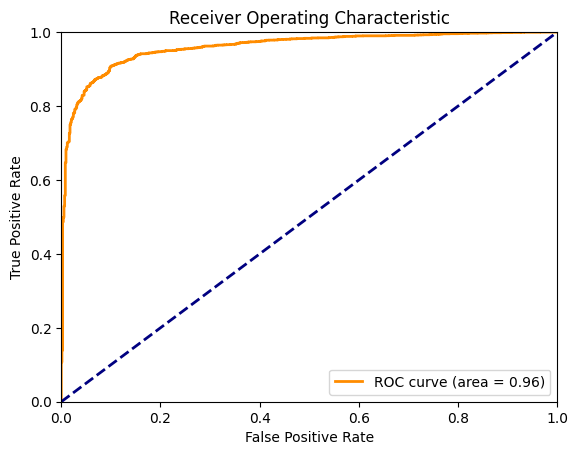

In [102]:
# weight decay: 0.01, batch size: 16
precision, recall, thresholds = draw_roc_curve(best_model, X_test, y_test)

In [158]:
print(precision, recall, thresholds)

[       nan 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.98448949 0.98678777 0.98687055 0.98789454 0.98796407
 0.98810077 0.98816796 0.98968269 0.98973324 0.98993058 0.98997874
 0.99014372 0.99018987 0.99087351 0.99091309 0.99123614 0.99127264
 0.9914332  0.99146808 0.9924106  0.99243799 0.99273932 0.99276439
 0.99278929 0.99281402 0.99328603 0.99330747 0.99333938 0.99336049
 0.99337099 0.9933919  0.99375617 0.98758984 0.98762648 0.9876629
 0.98869463 0.98872504 0.99049039 0.99051192 0.9908436  0.99086357
 0.99119008 0.99120856 0.99164665 0.99166327 0.99183384 0.98780057
 0.98784774 0.98386235 0.98400097 0.98403145 0.98410715 0.98413723
 0.98575483 0.985779   0.98625701 0.98627951

In [79]:
def evaluate_model_best_threshold(model, X_test, y_test, precision, recall, thresholds):
    
    # Find the best threshold   
    min_diff = float('inf')
    best_threshold = 0

    for p, r, t in zip(precision, recall, thresholds):
        if abs(p - 0.8) < 0.02 and abs(r - 0.8) < 0.02:
            diff = abs(p - 0.8) + abs(r - 0.8)
            if diff < min_diff:
                min_diff = diff
                best_threshold = t

    print(f'best threshold: {best_threshold}')
    
    # model evaluation
    model.eval()
    with torch.no_grad():
        y_test_list = []
        y_pred_list = [] 
        for seq, labels in zip(X_test, y_test):
            seq, labels = seq.to(device).float(), labels.to(device).float()
            y_pred = model(seq.unsqueeze(0))
            y_pred = (y_pred > best_threshold).float()
            
            y_test_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
  

    target_names = ['Non-Active', 'Active']
    print(classification_report(y_test_list, y_pred_list, target_names=target_names))

In [104]:
# threshold: 0, weight decay: 0.01, batch size: 16
evaluate_model_best_threshold(best_model, X_test, y_test, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.80      0.76      0.78       739
      Active       0.94      0.95      0.95      3097

    accuracy                           0.92      3836
   macro avg       0.87      0.86      0.86      3836
weighted avg       0.91      0.92      0.92      3836



In [106]:
# threshold: 0.01, weight decay: 0.01, batch size: 16
model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.05).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.78      0.76      0.77       739
      Active       0.94      0.95      0.95      3097

    accuracy                           0.91      3836
   macro avg       0.86      0.85      0.86      3836
weighted avg       0.91      0.91      0.91      3836



#### Use 2024/01-03 data, weight decay: 0.01

In [82]:
# weight decay: 0.01, batch size: 16
train_model(model, optimizer, dataloader_train, dataloader_val)

  7%|▋         | 7/100 [00:43<09:38,  6.22s/it]

Epoch 2520, Train Loss: 0.06369150, Val Loss: 0.21719678


 17%|█▋        | 17/100 [01:45<08:30,  6.15s/it]

Epoch 2530, Train Loss: 0.10241541, Val Loss: 0.11040992


 27%|██▋       | 27/100 [02:47<07:30,  6.18s/it]

Epoch 2540, Train Loss: 0.35127676, Val Loss: 0.21082287


 37%|███▋      | 37/100 [03:48<06:27,  6.15s/it]

Epoch 2550, Train Loss: 0.07515883, Val Loss: 0.00502228


 47%|████▋     | 47/100 [04:50<05:29,  6.21s/it]

Epoch 2560, Train Loss: 0.25553757, Val Loss: 0.00849541


 57%|█████▋    | 57/100 [05:52<04:27,  6.22s/it]

Epoch 2570, Train Loss: 0.44831464, Val Loss: 0.03507599


 67%|██████▋   | 67/100 [06:54<03:23,  6.17s/it]

Epoch 2580, Train Loss: 0.00594244, Val Loss: 0.01984359


 77%|███████▋  | 77/100 [07:56<02:21,  6.14s/it]

Epoch 2590, Train Loss: 0.04265221, Val Loss: 0.30816084


 87%|████████▋ | 87/100 [08:58<01:20,  6.19s/it]

Epoch 2600, Train Loss: 0.12533915, Val Loss: 0.08577123


 97%|█████████▋| 97/100 [09:59<00:18,  6.11s/it]

Epoch 2610, Train Loss: 0.41095695, Val Loss: 0.57602662


100%|██████████| 100/100 [10:18<00:00,  6.18s/it]


In [84]:
# weight 1:1, batch size: 16
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.71      0.74      0.73      2080
      Active       0.94      0.93      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.82      0.84      0.83     11171
weighted avg       0.90      0.90      0.90     11171



In [85]:
# weight 1:1, batch size: 16
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.82      0.87      0.85      7503
      Active       0.97      0.96      0.96     32711

    accuracy                           0.94     40214
   macro avg       0.90      0.91      0.90     40214
weighted avg       0.94      0.94      0.94     40214



In [86]:
# weight 1:1, batch size: 16
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.72      0.73      0.73       842
      Active       0.94      0.93      0.94      3627

    accuracy                           0.90      4469
   macro avg       0.83      0.83      0.83      4469
weighted avg       0.90      0.90      0.90      4469



##### Best Model

In [94]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_weightdecay001.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [95]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.70      0.76      0.73      2080
      Active       0.94      0.92      0.93      9091

    accuracy                           0.89     11171
   macro avg       0.82      0.84      0.83     11171
weighted avg       0.90      0.89      0.90     11171



In [96]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.87      0.83      7503
      Active       0.97      0.95      0.96     32711

    accuracy                           0.93     40214
   macro avg       0.88      0.91      0.89     40214
weighted avg       0.94      0.93      0.93     40214



In [97]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.71      0.76      0.74       842
      Active       0.94      0.93      0.94      3627

    accuracy                           0.90      4469
   macro avg       0.83      0.84      0.84      4469
weighted avg       0.90      0.90      0.90      4469



#### Use 2024/01-03 data, weight decay: 0.1

In [90]:
# weight decay: 0.01, batch size: 16
train_model(model, optimizer, dataloader_train, dataloader_val)

  7%|▋         | 7/100 [00:43<09:36,  6.20s/it]

Epoch 2520, Train Loss: 0.38507408, Val Loss: 0.35258484


 17%|█▋        | 17/100 [01:45<08:35,  6.21s/it]

Epoch 2530, Train Loss: 0.16178432, Val Loss: 0.07020643


 27%|██▋       | 27/100 [02:47<07:33,  6.22s/it]

Epoch 2540, Train Loss: 0.10472612, Val Loss: 0.15723711


 37%|███▋      | 37/100 [03:49<06:29,  6.18s/it]

Epoch 2550, Train Loss: 0.13172430, Val Loss: 0.09927483


 47%|████▋     | 47/100 [04:50<05:27,  6.18s/it]

Epoch 2560, Train Loss: 0.35648131, Val Loss: 0.03794042


 57%|█████▋    | 57/100 [05:52<04:27,  6.22s/it]

Epoch 2570, Train Loss: 0.34235391, Val Loss: 0.00157672


 67%|██████▋   | 67/100 [06:53<03:23,  6.15s/it]

Epoch 2580, Train Loss: 0.32237405, Val Loss: 0.01007630


 77%|███████▋  | 77/100 [07:55<02:22,  6.20s/it]

Epoch 2590, Train Loss: 0.35183677, Val Loss: 0.04308204


 87%|████████▋ | 87/100 [08:57<01:19,  6.15s/it]

Epoch 2600, Train Loss: 0.03423589, Val Loss: 0.26943243


 97%|█████████▋| 97/100 [09:59<00:18,  6.16s/it]

Epoch 2610, Train Loss: 0.07571718, Val Loss: 0.35867268


100%|██████████| 100/100 [10:17<00:00,  6.17s/it]


In [91]:
# weight 1:1, batch size: 16
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.71      0.78      0.74      2080
      Active       0.95      0.93      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.83      0.85      0.84     11171
weighted avg       0.90      0.90      0.90     11171



In [92]:
# weight 1:1, batch size: 16
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.74      0.80      0.77      7503
      Active       0.95      0.94      0.94     32711

    accuracy                           0.91     40214
   macro avg       0.85      0.87      0.86     40214
weighted avg       0.91      0.91      0.91     40214



In [93]:
# weight 1:1, batch size: 16
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.73      0.79      0.76       842
      Active       0.95      0.93      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.84      0.86      0.85      4469
weighted avg       0.91      0.91      0.91      4469



##### Best Model

In [98]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_weightdecay01.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [99]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.70      0.80      0.75      2080
      Active       0.95      0.92      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.83      0.86      0.84     11171
weighted avg       0.91      0.90      0.90     11171



In [100]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.73      0.82      0.77      7503
      Active       0.96      0.93      0.94     32711

    accuracy                           0.91     40214
   macro avg       0.84      0.88      0.86     40214
weighted avg       0.92      0.91      0.91     40214



In [101]:
# weight 1:1, batch size: 16
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.72      0.81      0.77       842
      Active       0.95      0.93      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.84      0.87      0.85      4469
weighted avg       0.91      0.91      0.91      4469



/var/tmp/ipykernel_352549/3255369871.py:18: RuntimeWarning: invalid value encountered in divide


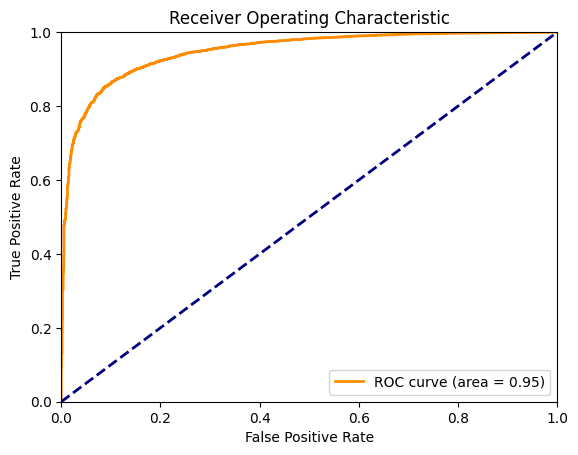

In [103]:
# weight decay: 0.01, batch size: 16
precision, recall, thresholds = draw_roc_curve(best_model, X_test, y_test)

In [105]:
# threshold: 0, weight decay: 0.1, batch size: 16
evaluate_model_best_threshold(best_model, X_test, y_test, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.75      0.74      0.75      2080
      Active       0.94      0.94      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.84     11171
weighted avg       0.91      0.91      0.91     11171



In [106]:
evaluate_model_best_threshold(best_model, X_train, y_train, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.78      0.75      0.77      7503
      Active       0.94      0.95      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.86      0.85      0.86     40214
weighted avg       0.91      0.91      0.91     40214



In [107]:
evaluate_model_best_threshold(best_model, X_val, y_val, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.76      0.74      0.75       842
      Active       0.94      0.95      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.85      0.84      0.85      4469
weighted avg       0.91      0.91      0.91      4469



In [108]:
# threshold: 0.1, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.1).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.75      0.75      0.75      2080
      Active       0.94      0.94      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.84      0.85      0.84     11171
weighted avg       0.91      0.91      0.91     11171



#### Test 2024/04 data

In [67]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[:, -1, :])
        return predictions

best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_weightdecay01.pt'
best_model = LSTMModel(input_size=X_30d.shape[2], output_size=1).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [70]:
evaluate_model(best_model, X_30d, y_30d)

              precision    recall  f1-score   support

  Non-Active       0.71      0.64      0.68      3667
      Active       0.93      0.94      0.93     17104

    accuracy                           0.89     20771
   macro avg       0.82      0.79      0.80     20771
weighted avg       0.89      0.89      0.89     20771



In [71]:
# threshold: 0.1, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_30d, y_30d):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.1).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.74      0.58      0.65      3667
      Active       0.91      0.96      0.94     17104

    accuracy                           0.89     20771
   macro avg       0.83      0.77      0.79     20771
weighted avg       0.88      0.89      0.89     20771



### Best Model Weight

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
batch_size = 16

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [62]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[:, -1, :])
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1) # lr rate decrease from 0.001 to 0.0001

In [43]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=200):
    
    best_val_loss = float('inf')
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                labels = labels
                
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')
        
        
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_weightdecay01.pt')

In [44]:
# weight decay: 0.1, batch size: 16
train_model(model, optimizer, dataloader_train, dataloader_val)

  4%|▍         | 8/200 [00:18<07:01,  2.20s/it]

Epoch 870, Train Loss: 0.03038145, Val Loss: 0.15959001


  9%|▉         | 18/200 [00:40<06:38,  2.19s/it]

Epoch 880, Train Loss: 0.22720101, Val Loss: 0.13562319


 14%|█▍        | 28/200 [01:01<06:11,  2.16s/it]

Epoch 890, Train Loss: 0.17586818, Val Loss: 0.69619459


 19%|█▉        | 38/200 [01:23<05:52,  2.17s/it]

Epoch 900, Train Loss: 0.19169669, Val Loss: 0.20014367


 24%|██▍       | 48/200 [01:45<05:29,  2.17s/it]

Epoch 910, Train Loss: 0.06677651, Val Loss: 0.40253845


 29%|██▉       | 58/200 [02:07<05:11,  2.20s/it]

Epoch 920, Train Loss: 0.13925242, Val Loss: 0.07959162


 34%|███▍      | 68/200 [02:28<04:48,  2.19s/it]

Epoch 930, Train Loss: 0.14678483, Val Loss: 0.14342360


 39%|███▉      | 78/200 [02:50<04:24,  2.17s/it]

Epoch 940, Train Loss: 0.39769575, Val Loss: 0.17421110


 44%|████▍     | 88/200 [03:12<04:02,  2.17s/it]

Epoch 950, Train Loss: 0.03545769, Val Loss: 0.12957881


 49%|████▉     | 98/200 [03:33<03:41,  2.17s/it]

Epoch 960, Train Loss: 0.25803030, Val Loss: 0.12242822


 54%|█████▍    | 108/200 [03:55<03:21,  2.19s/it]

Epoch 970, Train Loss: 0.31715864, Val Loss: 0.17230402


 59%|█████▉    | 118/200 [04:17<02:57,  2.17s/it]

Epoch 980, Train Loss: 0.32386026, Val Loss: 0.18333691


 64%|██████▍   | 128/200 [04:39<02:36,  2.18s/it]

Epoch 990, Train Loss: 0.42777961, Val Loss: 0.06886286


 69%|██████▉   | 138/200 [05:00<02:13,  2.15s/it]

Epoch 1000, Train Loss: 0.12190882, Val Loss: 0.36389980


 74%|███████▍  | 148/200 [05:22<01:51,  2.15s/it]

Epoch 1010, Train Loss: 0.00395266, Val Loss: 0.09976592


 79%|███████▉  | 158/200 [05:44<01:30,  2.16s/it]

Epoch 1020, Train Loss: 0.11231443, Val Loss: 0.14829111


 84%|████████▍ | 168/200 [06:06<01:09,  2.16s/it]

Epoch 1030, Train Loss: 0.22834820, Val Loss: 0.81409758


 89%|████████▉ | 178/200 [06:27<00:47,  2.18s/it]

Epoch 1040, Train Loss: 0.11397294, Val Loss: 0.47181901


 94%|█████████▍| 188/200 [06:49<00:25,  2.15s/it]

Epoch 1050, Train Loss: 0.19501264, Val Loss: 0.14171481


 99%|█████████▉| 198/200 [07:11<00:04,  2.17s/it]

Epoch 1060, Train Loss: 0.11663672, Val Loss: 0.15920196


100%|██████████| 200/200 [07:15<00:00,  2.18s/it]


In [63]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_weightdecay01.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

RuntimeError: Error(s) in loading state_dict for LSTMModel:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 87]) from checkpoint, the shape in current model is torch.Size([512, 86]).

In [46]:
# weight decay: 0.01, batch size: 16
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.75      0.83      0.79       739
      Active       0.96      0.93      0.95      3097

    accuracy                           0.91      3836
   macro avg       0.85      0.88      0.87      3836
weighted avg       0.92      0.91      0.91      3836



In [47]:
# weight decay: 0.01, batch size: 16
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.77      0.88      0.82      2688
      Active       0.97      0.94      0.95     11118

    accuracy                           0.92     13806
   macro avg       0.87      0.91      0.89     13806
weighted avg       0.93      0.92      0.93     13806



In [48]:
# weight decay: 0.01, batch size: 16
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.76      0.84      0.80       310
      Active       0.96      0.93      0.95      1224

    accuracy                           0.91      1534
   macro avg       0.86      0.89      0.87      1534
weighted avg       0.92      0.91      0.92      1534



/var/tmp/ipykernel_145236/3255369871.py:18: RuntimeWarning: invalid value encountered in divide


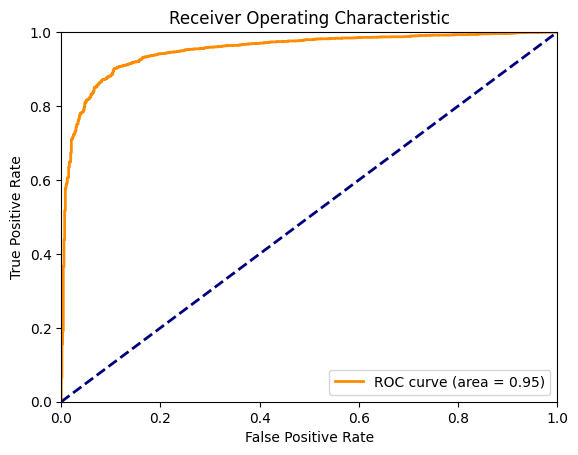

In [52]:
# ROC Curve
precision, recall, thresholds = draw_roc_curve(best_model, X_test, y_test)

In [53]:
# best threshold
evaluate_model_best_threshold(best_model, X_test, y_test, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.78      0.76      0.77       739
      Active       0.94      0.95      0.95      3097

    accuracy                           0.91      3836
   macro avg       0.86      0.86      0.86      3836
weighted avg       0.91      0.91      0.91      3836



In [60]:
# threshold: 0.05, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.05).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.78      0.77      0.77       739
      Active       0.94      0.95      0.95      3097

    accuracy                           0.91      3836
   macro avg       0.86      0.86      0.86      3836
weighted avg       0.91      0.91      0.91      3836



In [48]:
# threshold: 0.05, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.05).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.60      0.88      0.71       571
      Active       0.97      0.88      0.92      2796

    accuracy                           0.88      3367
   macro avg       0.79      0.88      0.82      3367
weighted avg       0.91      0.88      0.89      3367



In [42]:
## 2024/02
# weight decay: 0.01, batch size: 16
evaluate_model(best_model, X_30d, y_30d)

              precision    recall  f1-score   support

  Non-Active       0.59      0.88      0.71      2937
      Active       0.97      0.87      0.92     13895

    accuracy                           0.87     16832
   macro avg       0.78      0.88      0.82     16832
weighted avg       0.91      0.87      0.88     16832



In [43]:
# threshold: 0, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_30d, y_30d):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.65      0.83      0.73      2937
      Active       0.96      0.91      0.93     13895

    accuracy                           0.89     16832
   macro avg       0.81      0.87      0.83     16832
weighted avg       0.91      0.89      0.90     16832



### Experiment: Upsampling

In [132]:
batch_size = 16

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [133]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[:, -1, :])
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [134]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    # patience = 20
    best_val_loss = float('inf')
    # counter = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                labels = labels
                
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')
        
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_upsampling.pt')

In [135]:
train_model(model, optimizer, dataloader_train, dataloader_val)

  3%|▎         | 3/100 [00:30<16:17, 10.07s/it]

Epoch 4090, Train Loss: 0.20398912, Val Loss: 0.06575281


 13%|█▎        | 13/100 [02:09<14:24,  9.94s/it]

Epoch 4100, Train Loss: 0.16024885, Val Loss: 0.51484662


 23%|██▎       | 23/100 [03:49<12:51, 10.02s/it]

Epoch 4110, Train Loss: 0.04552924, Val Loss: 0.00713516


 33%|███▎      | 33/100 [05:29<11:08,  9.97s/it]

Epoch 4120, Train Loss: 0.00131742, Val Loss: 0.01846393


 43%|████▎     | 43/100 [07:09<09:31, 10.02s/it]

Epoch 4130, Train Loss: 0.00593301, Val Loss: 0.00034072


 53%|█████▎    | 53/100 [08:49<07:50, 10.02s/it]

Epoch 4140, Train Loss: 0.00652777, Val Loss: 0.00776697


 63%|██████▎   | 63/100 [10:30<06:11, 10.05s/it]

Epoch 4150, Train Loss: 0.00007352, Val Loss: 1.25873935


 73%|███████▎  | 73/100 [12:10<04:28,  9.95s/it]

Epoch 4160, Train Loss: 0.00038490, Val Loss: 0.00048685


 83%|████████▎ | 83/100 [13:50<02:49,  9.99s/it]

Epoch 4170, Train Loss: 0.02712921, Val Loss: 0.00343889


 93%|█████████▎| 93/100 [15:29<01:09,  9.98s/it]

Epoch 4180, Train Loss: 0.00078315, Val Loss: 0.00270475


100%|██████████| 100/100 [16:40<00:00, 10.01s/it]


In [136]:
# only upsampling
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.66      0.74      0.70      2080
      Active       0.94      0.91      0.93      9091

    accuracy                           0.88     11171
   macro avg       0.80      0.83      0.81     11171
weighted avg       0.89      0.88      0.88     11171



In [137]:
# only upsampling
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.99      1.00      1.00     32752
      Active       1.00      0.99      1.00     32656

    accuracy                           1.00     65408
   macro avg       1.00      1.00      1.00     65408
weighted avg       1.00      1.00      1.00     65408



In [138]:
# only upsampling
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.93      0.99      0.96      3586
      Active       0.99      0.92      0.96      3682

    accuracy                           0.96      7268
   macro avg       0.96      0.96      0.96      7268
weighted avg       0.96      0.96      0.96      7268



In [145]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_upsampling.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [146]:
# only upsampling
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.68      0.73      0.70      2080
      Active       0.94      0.92      0.93      9091

    accuracy                           0.88     11171
   macro avg       0.81      0.83      0.82     11171
weighted avg       0.89      0.88      0.89     11171



In [147]:
# only upsampling
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       1.00      1.00      1.00     32752
      Active       1.00      1.00      1.00     32656

    accuracy                           1.00     65408
   macro avg       1.00      1.00      1.00     65408
weighted avg       1.00      1.00      1.00     65408



In [148]:
# only upsampling
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.93      0.99      0.96      3586
      Active       0.99      0.93      0.96      3682

    accuracy                           0.96      7268
   macro avg       0.96      0.96      0.96      7268
weighted avg       0.96      0.96      0.96      7268



In [149]:
# threshold: 0.05, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.05).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.68      0.72      0.70      2080
      Active       0.94      0.92      0.93      9091

    accuracy                           0.89     11171
   macro avg       0.81      0.82      0.82     11171
weighted avg       0.89      0.89      0.89     11171



#### Add Weight decay: 0.1

In [139]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[:, -1, :])
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)

In [140]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    # patience = 20
    best_val_loss = float('inf')
    # counter = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                labels = labels
                
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')

        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_upsampling_weightdecay01.pt')

In [141]:
train_model(model, optimizer, dataloader_train, dataloader_val)

  3%|▎         | 3/100 [00:29<16:03,  9.94s/it]

Epoch 4090, Train Loss: 0.33691210, Val Loss: 0.35739571


 13%|█▎        | 13/100 [02:08<14:17,  9.85s/it]

Epoch 4100, Train Loss: 0.11941333, Val Loss: 0.03405338


 23%|██▎       | 23/100 [03:47<12:40,  9.88s/it]

Epoch 4110, Train Loss: 0.19300456, Val Loss: 0.03846744


 33%|███▎      | 33/100 [05:26<11:02,  9.89s/it]

Epoch 4120, Train Loss: 0.24498452, Val Loss: 0.16899209


 43%|████▎     | 43/100 [07:05<09:26,  9.93s/it]

Epoch 4130, Train Loss: 0.24105355, Val Loss: 0.18300922


 53%|█████▎    | 53/100 [08:44<07:43,  9.86s/it]

Epoch 4140, Train Loss: 0.18863471, Val Loss: 0.12422143


 63%|██████▎   | 63/100 [10:23<06:03,  9.84s/it]

Epoch 4150, Train Loss: 0.20336358, Val Loss: 0.12949733


 73%|███████▎  | 73/100 [12:02<04:27,  9.92s/it]

Epoch 4160, Train Loss: 0.07592870, Val Loss: 0.92232358


 83%|████████▎ | 83/100 [13:41<02:48,  9.90s/it]

Epoch 4170, Train Loss: 0.37206316, Val Loss: 0.28032440


 93%|█████████▎| 93/100 [15:19<01:09,  9.86s/it]

Epoch 4180, Train Loss: 0.15825924, Val Loss: 0.13190390


100%|██████████| 100/100 [16:29<00:00,  9.89s/it]


In [142]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.58      0.89      0.70      2080
      Active       0.97      0.85      0.91      9091

    accuracy                           0.86     11171
   macro avg       0.78      0.87      0.81     11171
weighted avg       0.90      0.86      0.87     11171



In [143]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.89      0.97      0.93     32752
      Active       0.97      0.88      0.92     32656

    accuracy                           0.92     65408
   macro avg       0.93      0.92      0.92     65408
weighted avg       0.93      0.92      0.92     65408



In [144]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.58      0.89      0.70      2080
      Active       0.97      0.85      0.91      9091

    accuracy                           0.86     11171
   macro avg       0.78      0.87      0.81     11171
weighted avg       0.90      0.86      0.87     11171



/var/tmp/ipykernel_443239/3255369871.py:18: RuntimeWarning: invalid value encountered in divide


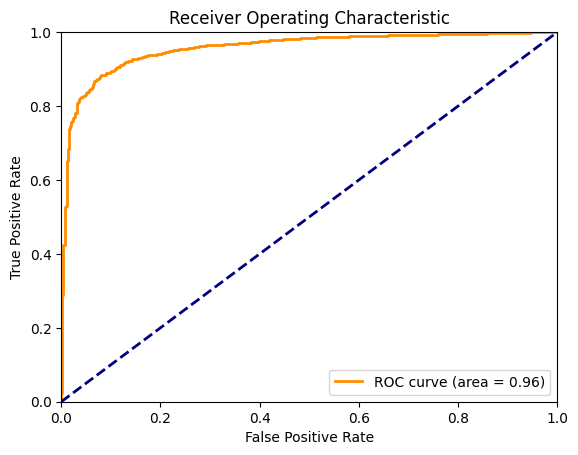

In [124]:
# ROC Curve
precision, recall, thresholds = draw_roc_curve(model, X_test, y_test)

In [128]:
# best threshold
evaluate_model_best_threshold(model, X_test, y_test, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.68      0.89      0.77       739
      Active       0.97      0.90      0.93      3097

    accuracy                           0.90      3836
   macro avg       0.82      0.90      0.85      3836
weighted avg       0.92      0.90      0.90      3836



### Experiment: 10-day seq

In [47]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X_10d, y_10d, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.1, random_state=42)

In [48]:
y_train.sum()/len(y_train)

0.8417105393861131

In [49]:
y_val.sum()/len(y_val)

0.8328491620111732

In [50]:
y_test.sum()/len(y_test)

0.8402467369926694

In [51]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().unsqueeze(-1)

In [52]:
batch_size = 32

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[:, -1, :])
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    patience = 20
    best_val_loss = float('inf')
    counter = 0
    epoch = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        epoch += 1
        for batch in dataloader_train:
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
        
        train_losses.append(loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                val_pred = model(seqs)
                labels = labels
                val_loss = loss_function(val_pred, labels)
            val_losses.append(val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {loss.item():10.8f}, Val Loss: {val_loss.item():10.8f}')

            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_10seq.pt')

In [56]:
train_model(model, optimizer, dataloader_train, dataloader_val)

 10%|█         | 10/100 [00:32<04:47,  3.19s/it]

Epoch  10, Train Loss: 0.04264095, Val Loss: 0.24371973


 20%|██        | 20/100 [01:04<04:11,  3.14s/it]

Epoch  20, Train Loss: 0.23522010, Val Loss: 0.16347097


 30%|███       | 30/100 [01:35<03:39,  3.14s/it]

Epoch  30, Train Loss: 0.07473096, Val Loss: 0.42824221


 40%|████      | 40/100 [02:07<03:10,  3.18s/it]

Epoch  40, Train Loss: 0.00000014, Val Loss: 0.44953263


 50%|█████     | 50/100 [02:38<02:39,  3.18s/it]

Epoch  50, Train Loss: 0.00262834, Val Loss: 1.46391189


 60%|██████    | 60/100 [03:10<02:06,  3.17s/it]

Epoch  60, Train Loss: 0.99408716, Val Loss: 0.56096768


 70%|███████   | 70/100 [03:42<01:34,  3.16s/it]

Epoch  70, Train Loss: 0.37131542, Val Loss: 0.86029577


 80%|████████  | 80/100 [04:13<01:03,  3.15s/it]

Epoch  80, Train Loss: 0.00007720, Val Loss: 0.54099083


 90%|█████████ | 90/100 [04:45<00:31,  3.17s/it]

Epoch  90, Train Loss: 0.00318744, Val Loss: 1.91090381


100%|██████████| 100/100 [05:17<00:00,  3.17s/it]

Epoch 100, Train Loss: 0.00022069, Val Loss: 0.37030679


In [59]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.69      0.71      0.70      1787
      Active       0.94      0.94      0.94      9399

    accuracy                           0.90     11186
   macro avg       0.82      0.82      0.82     11186
weighted avg       0.90      0.90      0.90     11186



In [60]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.96      0.99      0.98      6374
      Active       1.00      0.99      1.00     33894

    accuracy                           0.99     40268
   macro avg       0.98      0.99      0.99     40268
weighted avg       0.99      0.99      0.99     40268



In [61]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.72      0.71      0.71       748
      Active       0.94      0.94      0.94      3727

    accuracy                           0.90      4475
   macro avg       0.83      0.83      0.83      4475
weighted avg       0.90      0.90      0.90      4475



In [62]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_10seq.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [63]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.68      0.68      0.68      1787
      Active       0.94      0.94      0.94      9399

    accuracy                           0.90     11186
   macro avg       0.81      0.81      0.81     11186
weighted avg       0.90      0.90      0.90     11186



In [64]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.96      0.98      0.97      6374
      Active       1.00      0.99      1.00     33894

    accuracy                           0.99     40268
   macro avg       0.98      0.99      0.98     40268
weighted avg       0.99      0.99      0.99     40268



In [65]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.70      0.66      0.68       748
      Active       0.93      0.94      0.94      3727

    accuracy                           0.90      4475
   macro avg       0.82      0.80      0.81      4475
weighted avg       0.89      0.90      0.89      4475



#### Experiment: weight decay 0.1

In [66]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, batch_size=32):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        predictions = self.fc(out[:, -1, :])
        return predictions

model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01) # lr rate decrease from 0.001 to 0.0001

In [67]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for batch in dataloader_train:
            epoch += 1
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            labels = labels

            loss = loss_function(y_pred, labels)
            weights = torch.where(labels == 1, 1.0, 1.0).to(y_pred.device)
            weighted_loss = (loss * weights).mean()
            weighted_loss.backward()
            optimizer.step()
        
        train_losses.append(weighted_loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                
                val_pred = model(seqs)
                labels = labels
                
                val_loss = loss_function(val_pred, labels)
                val_weights = torch.where(labels == 1, 1.0, 1.0).to(val_pred.device)
                weighted_val_loss = (val_loss * val_weights).mean()
            val_losses.append(weighted_val_loss.item())
        
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {weighted_loss.item():10.8f}, Val Loss: {weighted_val_loss.item():10.8f}')
        
        
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/single_step_lstm_best_model_10seq_weightdecay01.pt')

In [68]:
train_model(model, optimizer, dataloader_train, dataloader_val)

  2%|▏         | 2/100 [00:06<05:35,  3.43s/it]

Epoch 1260, Train Loss: 0.63990319, Val Loss: 0.28140566


 12%|█▏        | 12/100 [00:40<05:02,  3.43s/it]

Epoch 1270, Train Loss: 0.22586279, Val Loss: 0.15605453


 22%|██▏       | 22/100 [01:14<04:27,  3.42s/it]

Epoch 1280, Train Loss: 0.26607740, Val Loss: 0.15283974


 32%|███▏      | 32/100 [01:49<03:50,  3.39s/it]

Epoch 1290, Train Loss: 0.26023120, Val Loss: 0.23463506


 42%|████▏     | 42/100 [02:23<03:17,  3.41s/it]

Epoch 1300, Train Loss: 0.30565006, Val Loss: 0.14936571


 52%|█████▏    | 52/100 [02:57<02:43,  3.40s/it]

Epoch 1310, Train Loss: 0.44918212, Val Loss: 0.25799730


 62%|██████▏   | 62/100 [03:31<02:08,  3.37s/it]

Epoch 1320, Train Loss: 0.15533113, Val Loss: 0.20150746


 72%|███████▏  | 72/100 [04:05<01:36,  3.45s/it]

Epoch 1330, Train Loss: 0.23002510, Val Loss: 0.24834098


 82%|████████▏ | 82/100 [04:39<01:01,  3.40s/it]

Epoch 1340, Train Loss: 0.05688063, Val Loss: 0.20001611


 92%|█████████▏| 92/100 [05:13<00:27,  3.41s/it]

Epoch 1350, Train Loss: 0.04031694, Val Loss: 0.11204413


100%|██████████| 100/100 [05:40<00:00,  3.41s/it]


In [69]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.71      0.80      0.75      1787
      Active       0.96      0.94      0.95      9399

    accuracy                           0.92     11186
   macro avg       0.84      0.87      0.85     11186
weighted avg       0.92      0.92      0.92     11186



In [70]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.72      0.79      0.75      6374
      Active       0.96      0.94      0.95     33894

    accuracy                           0.92     40268
   macro avg       0.84      0.87      0.85     40268
weighted avg       0.92      0.92      0.92     40268



In [71]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.73      0.80      0.76       748
      Active       0.96      0.94      0.95      3727

    accuracy                           0.92      4475
   macro avg       0.84      0.87      0.85      4475
weighted avg       0.92      0.92      0.92      4475



In [72]:
best_model_path = '/home/jupyter/lstm/model/single_step_lstm_best_model_10seq_weightdecay01.pt'
best_model = LSTMModel(input_size=X_train.shape[2], output_size=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [73]:
# best model
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.70      0.82      0.75      1787
      Active       0.96      0.93      0.95      9399

    accuracy                           0.91     11186
   macro avg       0.83      0.88      0.85     11186
weighted avg       0.92      0.91      0.92     11186



In [74]:
# best model
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.70      0.82      0.75      6374
      Active       0.96      0.93      0.95     33894

    accuracy                           0.91     40268
   macro avg       0.83      0.88      0.85     40268
weighted avg       0.92      0.91      0.92     40268



In [75]:
# best model
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.70      0.82      0.75      1787
      Active       0.96      0.93      0.95      9399

    accuracy                           0.91     11186
   macro avg       0.83      0.88      0.85     11186
weighted avg       0.92      0.91      0.92     11186



/var/tmp/ipykernel_26893/3255369871.py:18: RuntimeWarning: invalid value encountered in divide


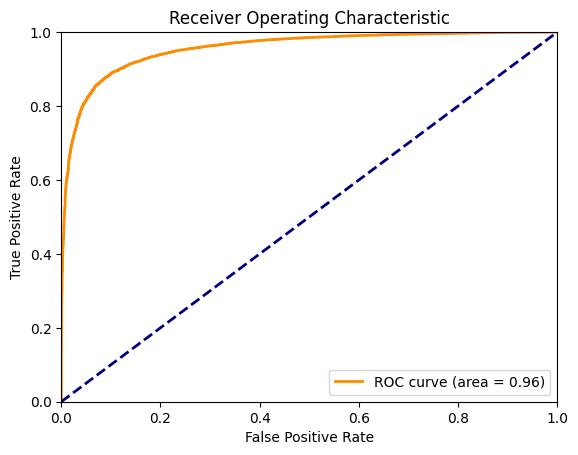

In [82]:
# ROC Curve
precision, recall, thresholds = draw_roc_curve(best_model, X_train, y_train)

In [83]:
evaluate_model_best_threshold(best_model, X_test, y_test, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.74      0.75      0.74      1787
      Active       0.95      0.95      0.95      9399

    accuracy                           0.92     11186
   macro avg       0.85      0.85      0.85     11186
weighted avg       0.92      0.92      0.92     11186



In [84]:
# threshold: 0.1, weight decay: 0.01, batch size: 16
model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.1).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.75      0.74      0.74      1787
      Active       0.95      0.95      0.95      9399

    accuracy                           0.92     11186
   macro avg       0.85      0.84      0.85     11186
weighted avg       0.92      0.92      0.92     11186



## Seq2Seq LSTM

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=1):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        
    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, hidden, cell):
        # Start token (we assume it's a zero vector of hidden_dim)
        batch_size = hidden.size(1)
        start_token = torch.zeros(batch_size, 1, hidden.size(2)).to(hidden.device)
        
        # Run LSTM with start token and hidden state from the encoder
        output, (hidden, cell) = self.lstm(start_token, (hidden, cell))
        
        # Predict the next time step (i.e., month 8)
        prediction = torch.sigmoid(self.fc(output[:, -1, :]))
        return prediction

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, y, teacher_forcing_ratio):
        hidden, cell = self.encoder(x)
        prediction = self.decoder(hidden, cell)

        teacher_forcing = random.random() < teacher_forcing_ratio
        output = y.requires_grad_() if teacher_forcing else prediction
        
        return output

In [15]:
# Setting Hyperparmeter
input_dim = X_train.shape[2]
hidden_dim = 128
output_dim = y_train.shape[1]

encoder = Encoder(input_dim, hidden_dim)
decoder = Decoder(input_dim, hidden_dim, output_dim)
model = Seq2Seq(encoder, decoder).to(device)

# Loss function & Optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)

In [16]:
batch_size = 32

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [372]:
def train_model(model, optimizer, dataloader_train, dataloader_val, epochs=100):
    
    # patience = 20
    best_val_loss = float('inf')
    # counter = 0
    # epoch = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        epoch += 1
        for batch in dataloader_train:
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs, labels, 0.5)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
        
        train_losses.append(loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                val_pred = model(seqs, labels, 0)
                val_loss = loss_function(val_pred, labels)
            val_losses.append(val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {loss.item():10.8f}, Val Loss: {val_loss.item():10.8f}')
                
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/seq2seq_lstm_weightdecay_01_teacher.pt')

In [373]:
train_model(model, optimizer, dataloader_train, dataloader_val)

 10%|█         | 10/100 [00:28<04:21,  2.91s/it]

Epoch  10, Train Loss: 0.05068320, Val Loss: 0.26599127


 20%|██        | 20/100 [00:58<03:55,  2.94s/it]

Epoch  20, Train Loss: 0.00000000, Val Loss: 0.18574867


 30%|███       | 30/100 [01:27<03:24,  2.92s/it]

Epoch  30, Train Loss: 0.00000000, Val Loss: 0.12145469


 40%|████      | 40/100 [01:56<02:55,  2.92s/it]

Epoch  40, Train Loss: 0.17614858, Val Loss: 0.11835539


 50%|█████     | 50/100 [02:25<02:27,  2.95s/it]

Epoch  50, Train Loss: 0.07173031, Val Loss: 0.12932734


 60%|██████    | 60/100 [02:55<01:58,  2.97s/it]

Epoch  60, Train Loss: 0.07150859, Val Loss: 0.07597789


 70%|███████   | 70/100 [03:24<01:27,  2.92s/it]

Epoch  70, Train Loss: 0.00000000, Val Loss: 0.22363886


 80%|████████  | 80/100 [03:54<00:58,  2.91s/it]

Epoch  80, Train Loss: 0.29645076, Val Loss: 0.38572901


 90%|█████████ | 90/100 [04:23<00:29,  2.91s/it]

Epoch  90, Train Loss: 0.25755286, Val Loss: 0.18947302


100%|██████████| 100/100 [04:52<00:00,  2.93s/it]

Epoch 100, Train Loss: 0.00000000, Val Loss: 0.10308319


In [162]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_test_list = []
        y_pred_list = [] 
        for seq, labels in zip(X_test, y_test):
            seq, labels = seq.to(device).float(), labels.to(device).float()
            y_pred = model(seq.unsqueeze(0))
            y_pred = (y_pred > 0.5).float()
            
            y_test_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
    
    
    target_names = ['Non-Active', 'Active']
    print(classification_report(y_test_list, y_pred_list, target_names=target_names))

In [374]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_test_list = []
        y_pred_list = [] 
        for seq, labels in zip(X_test, y_test):
            seq, labels = seq.to(device).float(), labels.to(device).float()
            y_pred = model(seq.unsqueeze(0), labels.unsqueeze(0), 0)
            y_pred = (y_pred > 0.5).float()
            
            y_test_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
    
    
    target_names = ['Non-Active', 'Active']
    print(classification_report(y_test_list, y_pred_list, target_names=target_names))

### Early Stop

In [62]:
# early stop
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.79      0.74      0.76       739
      Active       0.94      0.95      0.95      3097

    accuracy                           0.91      3836
   macro avg       0.86      0.84      0.85      3836
weighted avg       0.91      0.91      0.91      3836



In [63]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.83      0.82      0.82      2688
      Active       0.96      0.96      0.96     11118

    accuracy                           0.93     13806
   macro avg       0.89      0.89      0.89     13806
weighted avg       0.93      0.93      0.93     13806



In [64]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.77      0.75      0.76       310
      Active       0.94      0.94      0.94      1224

    accuracy                           0.90      1534
   macro avg       0.85      0.84      0.85      1534
weighted avg       0.90      0.90      0.90      1534



### Last epoch weight

In [163]:
# last epoch weight
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.76      0.71      0.74      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.83      0.84     11171
weighted avg       0.90      0.91      0.90     11171



In [165]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.73      0.76      7503
      Active       0.94      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.87      0.84      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [164]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.78      0.71      0.74       842
      Active       0.93      0.95      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.83      0.84      4469
weighted avg       0.90      0.91      0.91      4469



### Teacher

In [375]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.75      0.74      0.75      2080
      Active       0.94      0.94      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.84     11171
weighted avg       0.91      0.91      0.91     11171



In [ ]:
evaluate_model(model, X_train, y_train)

In [ ]:
evaluate_model(model, X_val, y_val)

In [17]:
best_model_path = '/home/jupyter/lstm/model/seq2seq_lstm_weightdecay_01_teacher.pt'

input_dim = X_train.shape[2]
hidden_dim = 128
output_dim = y_train.shape[1]

encoder = Encoder(input_dim, hidden_dim)
decoder = Decoder(input_dim, hidden_dim, output_dim)
best_model = Seq2Seq(encoder, decoder).to(device)

best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [22]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.77      0.70      0.74      2080
      Active       0.93      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.83      0.84     11171
weighted avg       0.90      0.91      0.90     11171



In [23]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.80      0.71      0.75      7503
      Active       0.93      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.87      0.83      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [24]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.78      0.69      0.73       842
      Active       0.93      0.96      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.82      0.84      4469
weighted avg       0.90      0.91      0.90      4469



### Best Model

In [166]:
best_model_path = '/home/jupyter/lstm/model/seq2seq_lstm_weightdecay_01.pt'

input_dim = X_train.shape[2]
hidden_dim = 128
output_dim = y_train.shape[1]

encoder = Encoder(input_dim, hidden_dim)
decoder = Decoder(input_dim, hidden_dim, output_dim)
best_model = Seq2Seq(encoder, decoder).to(device)

best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [167]:
# best model weight
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.75      0.74      0.74      2080
      Active       0.94      0.94      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.84      0.84      0.84     11171
weighted avg       0.90      0.91      0.91     11171



In [168]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.77      0.75      0.76      7503
      Active       0.94      0.95      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.86      0.85      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [169]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.77      0.73      0.75       842
      Active       0.94      0.95      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.85      0.84      0.85      4469
weighted avg       0.91      0.91      0.91      4469



### Best Model & ROC

/var/tmp/ipykernel_374275/3255369871.py:18: RuntimeWarning: invalid value encountered in divide


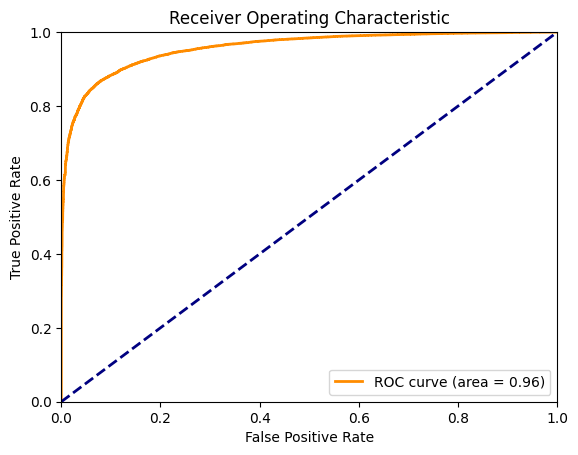

In [172]:
# weight decay: 0.01, batch size: 16
precision, recall, thresholds = draw_roc_curve(best_model, X_train, y_train)

In [174]:
# threshold: 0, weight decay: 0.01, batch size: 16
evaluate_model_best_threshold(best_model, X_test, y_test, precision, recall, thresholds)

best threshold: 0
              precision    recall  f1-score   support

  Non-Active       0.00      0.00      0.00      2080
      Active       0.81      1.00      0.90      9091

    accuracy                           0.81     11171
   macro avg       0.41      0.50      0.45     11171
weighted avg       0.66      0.81      0.73     11171



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [177]:
# threshold: 0.1, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.6).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.71      0.79      0.75      2080
      Active       0.95      0.93      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.83      0.86      0.84     11171
weighted avg       0.91      0.90      0.90     11171



In [178]:
# threshold: 0.1, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.4).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.78      0.67      0.72      2080
      Active       0.93      0.96      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.86      0.82      0.83     11171
weighted avg       0.90      0.90      0.90     11171



## GRU

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
batch_size = 32

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [38]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.extracter = nn.Linear(input_dim, input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.mid_fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = self.dropout(self.relu(self.extracter(x)))
        _, hidden = self.gru(x)
        mid_output = self.dropout(self.relu(self.mid_fc(hidden[-1])))
        output = torch.sigmoid(self.fc(mid_output))
        return output

In [36]:
len(dataloader_train) / batch_size

39.28125

In [39]:
model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1]).to(device) # input_dim, hidden_dim, output_dim

# Loss function & Optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1) # , weight_decay=0.01

# Learning rate scheduler
epochs = 100
# steps_per_epoch = len(dataloader_train) // batch_size
total_steps = len(dataloader_train) * epochs
scheduler = OneCycleLR(optimizer, max_lr=0.0001, total_steps=total_steps, epochs=epochs)

In [40]:
def train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs):
    
    # patience = 20
    best_val_loss = float('inf')
    # counter = 0
    # epoch = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        epoch += 1
        for batch in dataloader_train:
            seqs, labels = batch
            seqs, labels = seqs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()

            y_pred = model(seqs)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        train_losses.append(loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels = batch
                seqs, labels = seqs.to(device).float(), labels.to(device).float()
                val_pred = model(seqs)
                val_pred = val_pred
                labels = labels
                val_loss = loss_function(val_pred, labels)
            val_losses.append(val_loss.item())
        
        # if epoch % 10 == 0:
        #     
        print(f'Epoch {epoch:3}, Train Loss: {loss.item():10.8f}, Val Loss: {val_loss.item():10.8f}')
        current_lr = scheduler.get_last_lr()[0]
        print(f'Epoch {epoch:3}, Loss: {loss.item()}, Learning Rate: {current_lr}')


                
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/gru_best_model_weightdecay01_v3.pt')
    
    
    plt.plot(list(range(1, epochs+1, 1)), val_losses)
    plt.plot(list(range(1, epochs+1, 1)), train_losses)
    plt.xlabel('Model Complexity')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. Model Complexity')
    plt.show()

In [41]:
train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs)

  1%|          | 1/100 [00:03<06:08,  3.72s/it]

Epoch   1, Train Loss: 0.55787051, Val Loss: 0.58009636
Epoch   1, Loss: 0.5578705072402954, Learning Rate: 4.2629629559807634e-06


  2%|▏         | 2/100 [00:07<06:01,  3.68s/it]

Epoch   2, Train Loss: 0.41817069, Val Loss: 0.59279424
Epoch   2, Loss: 0.418170690536499, Learning Rate: 5.048970594080608e-06


  3%|▎         | 3/100 [00:11<05:59,  3.71s/it]

Epoch   3, Train Loss: 0.30229703, Val Loss: 0.46863639
Epoch   3, Loss: 0.30229702591896057, Learning Rate: 6.349410793802135e-06


  4%|▍         | 4/100 [00:14<05:53,  3.69s/it]

Epoch   4, Train Loss: 0.34397143, Val Loss: 0.40554142
Epoch   4, Loss: 0.3439714312553406, Learning Rate: 8.150034905187202e-06


  5%|▌         | 5/100 [00:18<05:52,  3.72s/it]

Epoch   5, Train Loss: 0.32351860, Val Loss: 0.40844390
Epoch   5, Loss: 0.3235186040401459, Learning Rate: 1.043111386827998e-05


  6%|▌         | 6/100 [00:22<05:48,  3.71s/it]

Epoch   6, Train Loss: 0.27127719, Val Loss: 0.30626890
Epoch   6, Loss: 0.27127718925476074, Learning Rate: 1.3167654380290438e-05


  7%|▋         | 7/100 [00:25<05:44,  3.71s/it]

Epoch   7, Train Loss: 0.57582104, Val Loss: 0.19754046
Epoch   7, Loss: 0.575821042060852, Learning Rate: 1.6329672741960283e-05


  8%|▊         | 8/100 [00:29<05:45,  3.76s/it]

Epoch   8, Train Loss: 0.30956259, Val Loss: 0.25126675
Epoch   8, Loss: 0.3095625936985016, Learning Rate: 1.9882523382654094e-05


  9%|▉         | 9/100 [00:33<05:39,  3.74s/it]

Epoch   9, Train Loss: 0.19851108, Val Loss: 0.15780149
Epoch   9, Loss: 0.19851107895374298, Learning Rate: 2.3787278464595425e-05


 10%|█         | 10/100 [00:37<05:34,  3.72s/it]

Epoch  10, Train Loss: 0.16394930, Val Loss: 0.25422794
Epoch  10, Loss: 0.16394929587841034, Learning Rate: 2.800115440700391e-05


 11%|█         | 11/100 [00:40<05:32,  3.73s/it]

Epoch  11, Train Loss: 0.19672364, Val Loss: 0.22723471
Epoch  11, Loss: 0.19672363996505737, Learning Rate: 3.247798065679823e-05


 12%|█▏        | 12/100 [00:44<05:25,  3.70s/it]

Epoch  12, Train Loss: 0.17419596, Val Loss: 0.19013095
Epoch  12, Loss: 0.17419596016407013, Learning Rate: 3.7168705569642636e-05


 13%|█▎        | 13/100 [00:48<05:23,  3.72s/it]

Epoch  13, Train Loss: 0.22634156, Val Loss: 0.23452841
Epoch  13, Loss: 0.22634156048297882, Learning Rate: 4.2021933858504865e-05


 14%|█▍        | 14/100 [00:52<05:21,  3.73s/it]

Epoch  14, Train Loss: 0.11879089, Val Loss: 0.21698886
Epoch  14, Loss: 0.1187908872961998, Learning Rate: 4.698448972101454e-05


 15%|█▌        | 15/100 [00:55<05:18,  3.74s/it]

Epoch  15, Train Loss: 0.25818461, Val Loss: 0.20688610
Epoch  15, Loss: 0.25818461179733276, Learning Rate: 5.200199947555397e-05


 16%|█▌        | 16/100 [00:59<05:15,  3.75s/it]

Epoch  16, Train Loss: 0.10646139, Val Loss: 0.34558791
Epoch  16, Loss: 0.10646139085292816, Learning Rate: 5.7019487322259976e-05


 17%|█▋        | 17/100 [01:03<05:10,  3.74s/it]

Epoch  17, Train Loss: 0.20748113, Val Loss: 0.10302392
Epoch  17, Loss: 0.20748113095760345, Learning Rate: 6.198197770130893e-05


 18%|█▊        | 18/100 [01:07<05:07,  3.75s/it]

Epoch  18, Train Loss: 0.15284292, Val Loss: 0.36230174
Epoch  18, Loss: 0.1528429239988327, Learning Rate: 6.683509764857161e-05


 19%|█▉        | 19/100 [01:10<05:04,  3.76s/it]

Epoch  19, Train Loss: 0.08620037, Val Loss: 0.20909461
Epoch  19, Loss: 0.08620037138462067, Learning Rate: 7.152567254875382e-05


 20%|██        | 20/100 [01:14<04:59,  3.75s/it]

Epoch  20, Train Loss: 0.12151117, Val Loss: 0.28471592
Epoch  20, Loss: 0.12151116877794266, Learning Rate: 7.60023087584805e-05


 21%|██        | 21/100 [01:18<04:56,  3.75s/it]

Epoch  21, Train Loss: 0.25026479, Val Loss: 0.47827911
Epoch  21, Loss: 0.2502647936344147, Learning Rate: 8.021595671564498e-05


 22%|██▏       | 22/100 [01:22<04:53,  3.76s/it]

Epoch  22, Train Loss: 0.23265900, Val Loss: 0.27768195
Epoch  22, Loss: 0.2326589971780777, Learning Rate: 8.412044836515233e-05


 23%|██▎       | 23/100 [01:26<04:52,  3.79s/it]

Epoch  23, Train Loss: 0.19316523, Val Loss: 0.29922438
Epoch  23, Loss: 0.19316522777080536, Learning Rate: 8.767300301259602e-05


 24%|██▍       | 24/100 [01:29<04:46,  3.77s/it]

Epoch  24, Train Loss: 0.27470294, Val Loss: 0.15914103
Epoch  24, Loss: 0.27470293641090393, Learning Rate: 9.083469606333543e-05


 25%|██▌       | 25/100 [01:33<04:42,  3.77s/it]

Epoch  25, Train Loss: 0.18221444, Val Loss: 0.23878670
Epoch  25, Loss: 0.18221443891525269, Learning Rate: 9.357088551109864e-05


 26%|██▌       | 26/100 [01:37<04:36,  3.73s/it]

Epoch  26, Train Loss: 0.17761165, Val Loss: 0.06538530
Epoch  26, Loss: 0.17761164903640747, Learning Rate: 9.585159150316451e-05


 27%|██▋       | 27/100 [01:40<04:33,  3.75s/it]

Epoch  27, Train Loss: 0.18147664, Val Loss: 0.14171270
Epoch  27, Loss: 0.1814766377210617, Learning Rate: 9.765182482330818e-05


 28%|██▊       | 28/100 [01:44<04:28,  3.73s/it]

Epoch  28, Train Loss: 0.25100189, Val Loss: 0.17858006
Epoch  28, Loss: 0.25100189447402954, Learning Rate: 9.89518606933913e-05


 29%|██▉       | 29/100 [01:48<04:24,  3.72s/it]

Epoch  29, Train Loss: 0.25416997, Val Loss: 0.19923715
Epoch  29, Loss: 0.2541699707508087, Learning Rate: 9.973745489361064e-05


 30%|███       | 30/100 [01:52<04:20,  3.72s/it]

Epoch  30, Train Loss: 0.34908998, Val Loss: 0.18681698
Epoch  30, Loss: 0.34908998012542725, Learning Rate: 9.999999996813078e-05


 31%|███       | 31/100 [01:55<04:15,  3.70s/it]

Epoch  31, Train Loss: 0.21767738, Val Loss: 0.32747239
Epoch  31, Loss: 0.21767738461494446, Learning Rate: 9.994957340429934e-05


 32%|███▏      | 32/100 [01:59<04:10,  3.68s/it]

Epoch  32, Train Loss: 0.32276925, Val Loss: 0.12046246
Epoch  32, Loss: 0.32276925444602966, Learning Rate: 9.97985554498256e-05


 33%|███▎      | 33/100 [02:02<04:06,  3.67s/it]

Epoch  33, Train Loss: 0.16569310, Val Loss: 0.19002384
Epoch  33, Loss: 0.16569310426712036, Learning Rate: 9.954725023477196e-05


 34%|███▍      | 34/100 [02:06<04:03,  3.69s/it]

Epoch  34, Train Loss: 0.17997403, Val Loss: 0.22982112
Epoch  34, Loss: 0.1799740344285965, Learning Rate: 9.919616385439723e-05


 35%|███▌      | 35/100 [02:10<04:02,  3.73s/it]

Epoch  35, Train Loss: 0.05989427, Val Loss: 0.31089661
Epoch  35, Loss: 0.059894271194934845, Learning Rate: 9.874600334994796e-05


 36%|███▌      | 36/100 [02:14<03:57,  3.71s/it]

Epoch  36, Train Loss: 0.18902504, Val Loss: 0.20872453
Epoch  36, Loss: 0.18902504444122314, Learning Rate: 9.819767528477156e-05


 37%|███▋      | 37/100 [02:17<03:54,  3.73s/it]

Epoch  37, Train Loss: 0.12828968, Val Loss: 0.15959394
Epoch  37, Loss: 0.12828968465328217, Learning Rate: 9.755228391861838e-05


 38%|███▊      | 38/100 [02:21<03:53,  3.76s/it]

Epoch  38, Train Loss: 0.46115693, Val Loss: 0.19755338
Epoch  38, Loss: 0.4611569344997406, Learning Rate: 9.681112898380945e-05


 39%|███▉      | 39/100 [02:25<03:48,  3.75s/it]

Epoch  39, Train Loss: 0.29257318, Val Loss: 0.04428281
Epoch  39, Loss: 0.2925731837749481, Learning Rate: 9.597570306774865e-05


 40%|████      | 40/100 [02:29<03:43,  3.73s/it]

Epoch  40, Train Loss: 0.26904440, Val Loss: 0.29723307
Epoch  40, Loss: 0.2690443992614746, Learning Rate: 9.504768860705023e-05


 41%|████      | 41/100 [02:33<03:41,  3.75s/it]

Epoch  41, Train Loss: 0.25546366, Val Loss: 0.22317283
Epoch  41, Loss: 0.2554636597633362, Learning Rate: 9.402895449933542e-05


 42%|████▏     | 42/100 [02:36<03:34,  3.71s/it]

Epoch  42, Train Loss: 0.22721812, Val Loss: 0.43547076
Epoch  42, Loss: 0.2272181212902069, Learning Rate: 9.292155233952138e-05


 43%|████▎     | 43/100 [02:40<03:32,  3.72s/it]

Epoch  43, Train Loss: 0.13542059, Val Loss: 0.18131885
Epoch  43, Loss: 0.13542059063911438, Learning Rate: 9.172771228818198e-05


 44%|████▍     | 44/100 [02:44<03:27,  3.71s/it]

Epoch  44, Train Loss: 0.33233756, Val Loss: 0.09100112
Epoch  44, Loss: 0.33233755826950073, Learning Rate: 9.04498385803012e-05


 45%|████▌     | 45/100 [02:47<03:23,  3.70s/it]

Epoch  45, Train Loss: 0.30079460, Val Loss: 0.07113933
Epoch  45, Loss: 0.3007946014404297, Learning Rate: 8.909050468346397e-05


 46%|████▌     | 46/100 [02:51<03:19,  3.70s/it]

Epoch  46, Train Loss: 0.20926251, Val Loss: 0.15590513
Epoch  46, Loss: 0.20926250517368317, Learning Rate: 8.765244811523477e-05


 47%|████▋     | 47/100 [02:55<03:17,  3.72s/it]

Epoch  47, Train Loss: 0.21756458, Val Loss: 0.12026709
Epoch  47, Loss: 0.21756458282470703, Learning Rate: 8.613856493016166e-05


 48%|████▊     | 48/100 [02:58<03:13,  3.72s/it]

Epoch  48, Train Loss: 0.15356971, Val Loss: 0.52635241
Epoch  48, Loss: 0.15356971323490143, Learning Rate: 8.455190388750782e-05


 49%|████▉     | 49/100 [03:02<03:08,  3.70s/it]

Epoch  49, Train Loss: 0.23266767, Val Loss: 0.22518691
Epoch  49, Loss: 0.23266766965389252, Learning Rate: 8.289566031145615e-05


 50%|█████     | 50/100 [03:06<03:03,  3.67s/it]

Epoch  50, Train Loss: 0.21837452, Val Loss: 0.28248516
Epoch  50, Loss: 0.21837452054023743, Learning Rate: 8.117316965615154e-05


 51%|█████     | 51/100 [03:09<03:00,  3.68s/it]

Epoch  51, Train Loss: 0.08787612, Val Loss: 0.17089969
Epoch  51, Loss: 0.08787611871957779, Learning Rate: 7.938790078854023e-05


 52%|█████▏    | 52/100 [03:13<02:56,  3.68s/it]

Epoch  52, Train Loss: 0.26838028, Val Loss: 0.27062061
Epoch  52, Loss: 0.2683802843093872, Learning Rate: 7.754344900253327e-05


 53%|█████▎    | 53/100 [03:17<02:54,  3.71s/it]

Epoch  53, Train Loss: 0.06502317, Val Loss: 0.17444016
Epoch  53, Loss: 0.06502316892147064, Learning Rate: 7.564352877856322e-05


 54%|█████▍    | 54/100 [03:21<02:52,  3.74s/it]

Epoch  54, Train Loss: 0.15040192, Val Loss: 0.18281178
Epoch  54, Loss: 0.15040192008018494, Learning Rate: 7.369196630311475e-05


 55%|█████▌    | 55/100 [03:24<02:47,  3.72s/it]

Epoch  55, Train Loss: 0.07811432, Val Loss: 0.11413463
Epoch  55, Loss: 0.07811432331800461, Learning Rate: 7.169269176329436e-05


 56%|█████▌    | 56/100 [03:28<02:42,  3.70s/it]

Epoch  56, Train Loss: 0.16315827, Val Loss: 0.37529165
Epoch  56, Loss: 0.16315826773643494, Learning Rate: 6.964973143195654e-05


 57%|█████▋    | 57/100 [03:32<02:39,  3.71s/it]

Epoch  57, Train Loss: 0.15707317, Val Loss: 0.12026455
Epoch  57, Loss: 0.15707316994667053, Learning Rate: 6.756719955932607e-05


 58%|█████▊    | 58/100 [03:36<02:37,  3.75s/it]

Epoch  58, Train Loss: 0.28145701, Val Loss: 0.38633034
Epoch  58, Loss: 0.28145700693130493, Learning Rate: 6.54492900874456e-05


 59%|█████▉    | 59/100 [03:39<02:31,  3.71s/it]

Epoch  59, Train Loss: 0.06094230, Val Loss: 0.29541689
Epoch  59, Loss: 0.06094229966402054, Learning Rate: 6.330026820413457e-05


 60%|██████    | 60/100 [03:43<02:27,  3.69s/it]

Epoch  60, Train Loss: 0.15793128, Val Loss: 0.10733003
Epoch  60, Loss: 0.15793128311634064, Learning Rate: 6.112446175346842e-05


 61%|██████    | 61/100 [03:47<02:25,  3.72s/it]

Epoch  61, Train Loss: 0.15190753, Val Loss: 0.14402160
Epoch  61, Loss: 0.1519075334072113, Learning Rate: 5.8926252520076814e-05


 62%|██████▏   | 62/100 [03:50<02:20,  3.70s/it]

Epoch  62, Train Loss: 0.21777570, Val Loss: 0.19657172
Epoch  62, Loss: 0.21777570247650146, Learning Rate: 5.671006740481229e-05


 63%|██████▎   | 63/100 [03:54<02:18,  3.74s/it]

Epoch  63, Train Loss: 0.18705361, Val Loss: 0.39915320
Epoch  63, Loss: 0.1870536059141159, Learning Rate: 5.4480369509561295e-05


 64%|██████▍   | 64/100 [03:58<02:13,  3.72s/it]

Epoch  64, Train Loss: 0.31448379, Val Loss: 0.39856112
Epoch  64, Loss: 0.31448379158973694, Learning Rate: 5.2241649149150764e-05


 65%|██████▌   | 65/100 [04:01<02:09,  3.69s/it]

Epoch  65, Train Loss: 0.22597472, Val Loss: 0.17664938
Epoch  65, Loss: 0.22597472369670868, Learning Rate: 4.9998414808451786e-05


 66%|██████▌   | 66/100 [04:05<02:05,  3.70s/it]

Epoch  66, Train Loss: 0.21322668, Val Loss: 0.15551786
Epoch  66, Loss: 0.21322667598724365, Learning Rate: 4.775518406289102e-05


 67%|██████▋   | 67/100 [04:09<02:01,  3.67s/it]

Epoch  67, Train Loss: 0.13303714, Val Loss: 0.16838855
Epoch  67, Loss: 0.13303713500499725, Learning Rate: 4.551647448065496e-05


 67%|██████▋   | 67/100 [04:11<02:03,  3.76s/it]


KeyboardInterrupt: 

### Add Learning rate scheduler

In [44]:
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.76      0.74      0.75      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.85     11171
weighted avg       0.91      0.91      0.91     11171



In [45]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.75      0.77      7503
      Active       0.94      0.95      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.86      0.85      0.86     40214
weighted avg       0.91      0.91      0.91     40214



In [46]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.77      0.74      0.75       842
      Active       0.94      0.95      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.84      0.85      4469
weighted avg       0.91      0.91      0.91      4469



### Add Learning rate scheduler (Best Model)

In [47]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay01_v3.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [48]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.77      0.72      0.75      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.85     11171
weighted avg       0.91      0.91      0.91     11171



In [49]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.73      0.76      7503
      Active       0.94      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.87      0.84      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [50]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.79      0.72      0.75       842
      Active       0.94      0.95      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.84      0.85      4469
weighted avg       0.91      0.91      0.91      4469



### Last epoch weight (Vanilla)

In [206]:
# last epoch weight
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.68      0.70      0.69      2080
      Active       0.93      0.93      0.93      9091

    accuracy                           0.88     11171
   macro avg       0.81      0.81      0.81     11171
weighted avg       0.88      0.88      0.88     11171



In [207]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.97      0.98      0.98      7503
      Active       0.99      0.99      0.99     32711

    accuracy                           0.99     40214
   macro avg       0.98      0.98      0.98     40214
weighted avg       0.99      0.99      0.99     40214



In [208]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.71      0.67      0.69       842
      Active       0.92      0.94      0.93      3627

    accuracy                           0.89      4469
   macro avg       0.82      0.80      0.81      4469
weighted avg       0.88      0.89      0.88      4469



##### Weight decay

In [184]:
# last epoch weight
evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.78      0.71      0.74      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.86      0.83      0.84     11171
weighted avg       0.91      0.91      0.91     11171



In [185]:
evaluate_model(model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.81      0.72      0.76      7503
      Active       0.94      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.87      0.84      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [186]:
evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.79      0.70      0.74       842
      Active       0.93      0.96      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.83      0.84      4469
weighted avg       0.91      0.91      0.91      4469



### Best Model

#### no weight decay

In [251]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [252]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.69      0.67      0.68      2080
      Active       0.93      0.93      0.93      9091

    accuracy                           0.88     11171
   macro avg       0.81      0.80      0.80     11171
weighted avg       0.88      0.88      0.88     11171



In [253]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.97      0.98      0.98      7503
      Active       1.00      0.99      0.99     32711

    accuracy                           0.99     40214
   macro avg       0.98      0.99      0.99     40214
weighted avg       0.99      0.99      0.99     40214



In [254]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.69      0.65      0.67       842
      Active       0.92      0.93      0.93      3627

    accuracy                           0.88      4469
   macro avg       0.81      0.79      0.80      4469
weighted avg       0.88      0.88      0.88      4469



#### weight decay 0.1

In [260]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay01.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [261]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.74      0.77      0.75      2080
      Active       0.95      0.94      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.84      0.85      0.85     11171
weighted avg       0.91      0.91      0.91     11171



In [262]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.75      0.78      0.77      7503
      Active       0.95      0.94      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.85      0.86      0.86     40214
weighted avg       0.91      0.91      0.91     40214



In [263]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.76      0.78      0.77       842
      Active       0.95      0.94      0.95      3627

    accuracy                           0.91      4469
   macro avg       0.85      0.86      0.86      4469
weighted avg       0.91      0.91      0.91      4469



### Add Feature Extracter Layer & Add Regularization Layer after model ouput

#### Add Feature Extracter Layer, weight decay 0.1

In [279]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay01_v2.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [273]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.74      0.76      0.75      2080
      Active       0.95      0.94      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.84      0.85      0.85     11171
weighted avg       0.91      0.90      0.91     11171



In [274]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.76      0.78      0.77      7503
      Active       0.95      0.94      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.85      0.86      0.86     40214
weighted avg       0.91      0.91      0.91     40214



In [275]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.76      0.76      0.76       842
      Active       0.94      0.94      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.85      0.85      0.85      4469
weighted avg       0.91      0.91      0.91      4469



#### Add Feature Extracter Layer & Add Regularization Layer after model output, weight decay 0.1

In [280]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.76      0.72      0.74      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.84     11171
weighted avg       0.91      0.91      0.91     11171



In [281]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.73      0.76      7503
      Active       0.94      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.86      0.84      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [282]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.78      0.72      0.75       842
      Active       0.94      0.95      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.84      0.85      4469
weighted avg       0.91      0.91      0.91      4469



### Best model & Weight decay

In [187]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay01.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [188]:
evaluate_model(best_model, X_test, y_test)

              precision    recall  f1-score   support

  Non-Active       0.75      0.75      0.75      2080
      Active       0.94      0.94      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.84      0.85      0.85     11171
weighted avg       0.91      0.91      0.91     11171



In [189]:
evaluate_model(best_model, X_train, y_train)

              precision    recall  f1-score   support

  Non-Active       0.78      0.76      0.77      7503
      Active       0.94      0.95      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.86      0.85      0.86     40214
weighted avg       0.91      0.91      0.91     40214



In [190]:
evaluate_model(best_model, X_val, y_val)

              precision    recall  f1-score   support

  Non-Active       0.76      0.75      0.75       842
      Active       0.94      0.95      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.85      0.85      0.85      4469
weighted avg       0.91      0.91      0.91      4469



/var/tmp/ipykernel_374275/3255369871.py:18: RuntimeWarning: invalid value encountered in divide


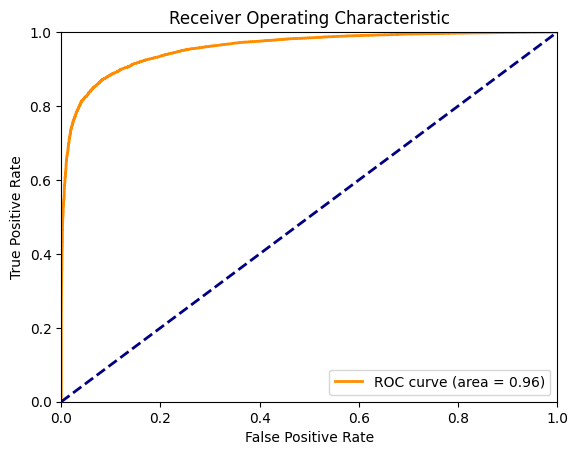

In [191]:
# weight decay: 0.01, batch size: 16
precision, recall, thresholds = draw_roc_curve(best_model, X_train, y_train)

In [193]:
# threshold: 0.1, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.6).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.71      0.80      0.75      2080
      Active       0.95      0.93      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.83      0.86      0.85     11171
weighted avg       0.91      0.90      0.90     11171



In [202]:
# threshold: 0.1, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.45).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.77      0.73      0.75      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.85     11171
weighted avg       0.91      0.91      0.91     11171



In [195]:
# threshold: 0.1, weight decay: 0.1, batch size: 16
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device).float(), labels.to(device).float()
        y_pred = best_model(seq.unsqueeze(0))
        y_pred = (y_pred > 0.35).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.81      0.65      0.72      2080
      Active       0.92      0.96      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.86      0.81      0.83     11171
weighted avg       0.90      0.91      0.90     11171

